# Reproduce data

# Load Packages

In [1]:
!pip -r requirements.txt


Usage:   
  pip <command> [options]

no such option: -r


In [2]:
import os
import sys

os.environ["SM_FRAMEWORK"] = "tf.keras"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Concatenate, Dropout, BatchNormalization, Activation, add, multiply, Conv2DTranspose, Layer, ZeroPadding2D, Add, Reshape, Lambda, SeparableConv2D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import mixed_precision

import segmentation_models as sm
from keras_segmentation.models import segnet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import pathlib
import requests

import pyunpack
import patoolib

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score

import rioxarray as rxr
   
print("-" * 30)
print(f"TensorFlow Version: {tf.__version__}")
print(f"Keras Backend: {K.backend()}")


Segmentation Models: using `tf.keras` framework.
------------------------------
TensorFlow Version: 2.10.0
Keras Backend: tensorflow


In [3]:
# Specify whether to download data or read in
download = True
base_dir = r"./Amazon Forest Dataset/"

In [4]:
base_dir = "./Amazon Forest Dataset/"

if os.path.exists(base_dir):
    files = os.listdir(base_dir)

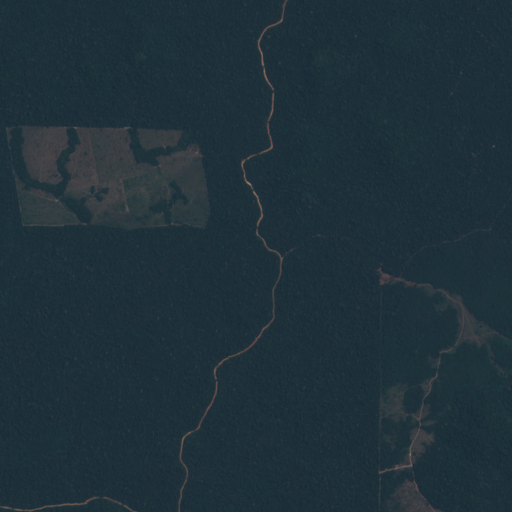

In [5]:
# Show example image from training data
PIL.Image.open(r"{}Training/images/Amazon_1110.tiff_25.tiff".format(base_dir))

# Functions

In [6]:
'''
  Returns an image plot of mask prediction
'''

def reconstruct_image(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])
  # Standardise between 0-1
  reconstruction = reconstruction/np.max(reconstruction)

  # Round to 0-1, binary pixel-by-pixel classification 
  if rounded:
    reconstruction = np.round(reconstruction)

  # Plot reconstructed mask (prediction)
  plt.imshow(reconstruction) 

In [7]:
'''
  Returns array of mask prediction, given model and image
'''
def reconstruct_array(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])

  if rounded:
    reconstruction = np.round(reconstruction)

  return reconstruction # Returns array

In [8]:
'''
  Metric functions for evaluation
'''

def score_eval(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return accuracy_score(mask.flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      reconstruction = model.predict(image[i].reshape(1, 512, 512, 3))
      reconstruction = np.round(reconstruction).flatten()

      scores.append(accuracy_score(mask[i].flatten(), reconstruction))

    return scores

def score_eval2(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return accuracy_score(mask.flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      reconstruction = model.predict(image[i].reshape(1, 512, 512, 4))
      reconstruction = np.round(reconstruction).flatten()

      scores.append(accuracy_score(mask[i].flatten(), reconstruction))

    return scores

def recall_eval(model, image, mask): # Find recall score
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return recall_score(mask.flatten(), reconstruction, average='weighted')

  else: # If a list of images input, find accuracy for each
    recall = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        recall.append(recall_score(mask[i].flatten(), reconstruction, average='weighted'))

    return recall

def precision_eval(model, image, mask): # Find precision score
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return precision_score(mask.flatten(), reconstruction, average='weighted')

  else: # If a list of images input, find accuracy for each
    precision = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        precision.append(precision_score(mask[i].flatten(), reconstruction, average='weighted'))

    return precision

def f1_score_eval(model, image, mask): # Find F1-score
    prec = np.mean(precision_eval(model, image, mask))
    rec = np.mean(recall_eval(model, image, mask))

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def f1_score_eval_basic(precision, recall):
    prec = np.mean(precision)
    rec = np.mean(recall)

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def produce_mask(image): # Outputs rounded image (binary)
  return np.round(image)

# Ingest and Process RGB Dataset

In [9]:
# Ingest images

## Training images
training_images_list = os.listdir(r"{}Training/images/".format(base_dir))
training_masks_list = []
training_images = []
for n in training_images_list:
  im = PIL.Image.open(r"{}Training/images/{}".format(base_dir,n))
  training_images.append(im)
  training_masks_list.append(n[:-5]+'.png')

## Training masks
training_masks = []
for n in training_masks_list:
  im = PIL.Image.open(r"{}Training/masks/{}".format(base_dir,n))
  training_masks.append(im)

## Test images
test_images_list = os.listdir(r"{}Test/".format(base_dir))
test_images = []
for n in test_images_list:
  im = PIL.Image.open(r"{}Test/{}".format(base_dir,n))
  test_images.append(im)

## Validation images
validation_images_list = os.listdir(r"{}Validation/images/".format(base_dir))
validation_masks_list = []
validation_images = []
for n in validation_images_list:
  im = PIL.Image.open(r"{}Validation/images/{}".format(base_dir,n))
  validation_images.append(im)
  validation_masks_list.append(n[:-5]+'.png')

## Validation masks
validation_masks = []
for n in validation_masks_list:
  im = PIL.Image.open(r"{}Validation/masks/{}".format(base_dir,n))
  validation_masks.append(im)

In [10]:
# Pre-process data, normalise and reshape
for i in range(len(training_images)):
  training_images[i] = np.array(training_images[i])/255
  training_images[i] = training_images[i].reshape(512,512,3)
  training_images[i] = training_images[i].astype('float32')

for i in range(len(training_masks)):
  training_masks[i] = (np.array(training_masks[i])-1)
  training_masks[i] = training_masks[i][:512,:512]
  training_masks[i] = training_masks[i].reshape(512,512,1)
  training_masks[i] = training_masks[i].astype('int')

for i in range(len(validation_images)):
  validation_images[i] = np.array(validation_images[i])/255
  validation_images[i] = validation_images[i].reshape(1,512,512,3)
  validation_images[i] = validation_images[i].astype('float32')

for i in range(len(validation_masks)):
  validation_masks[i] = np.array(validation_masks[i])-1
  validation_masks[i] = validation_masks[i][:512,:512]
  validation_masks[i] = validation_masks[i].reshape(1,512,512,1)
  validation_masks[i] = validation_masks[i].astype('int')

for i in range(len(test_images)):
  test_images[i] = np.array(test_images[i])/255
  test_images[i] = test_images[i].reshape(1,512,512,3)
  test_images[i] = test_images[i].astype('float32')

# Add some training images to validation data to increase size of validation set
for i in range(25,30):
  validation_images.append(training_images[i].reshape(1,512,512,3))
  validation_masks.append(training_masks[i].reshape(1,512,512,1))

# Remove five images from training data, which has been added to validation data
training_images = training_images[0:25]
training_masks = training_masks[0:25]

In [11]:
# Create TensorFlow datasets for validation sets
validation_df = tf.data.Dataset.from_tensor_slices((validation_images, validation_masks))

In [12]:
#
# Data loader/generator from: https://github.com/bragagnololu/UNet-defmapping.git
#

def adjustData(img, mask, num_class):
  
    mask[mask > 0.5] = 1 # FOREST
    mask[mask <= 0.5] = 0 # NON-FOREST

    return (img,mask)

def trainGenerator(batch_size,
                   image_array,
                   mask_array,
                   aug_dict,
                   image_save_prefix  = "image",
                   mask_save_prefix  = "mask",
                   num_class = 2,
                   save_to_dir = None,
                   target_size = (512,512),
                   seed = 1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow(image_array,
                                           batch_size = batch_size,
                                           save_to_dir = save_to_dir,
                                           save_prefix = image_save_prefix,
                                           seed = seed) 

    mask_generator = mask_datagen.flow(mask_array,
                                           batch_size = batch_size,
                                           save_to_dir = save_to_dir,
                                           save_prefix = mask_save_prefix,
                                           seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img,mask) in train_generator: 
        img, mask = adjustData(img, mask, num_class)
        yield (img, mask)

In [13]:
#
# Produce generators for training images
#

t_images = np.stack(training_images)
t_masks = np.stack(training_masks)

v_images = np.stack(validation_images)
v_masks = np.stack(validation_masks)

# Set parameters for data augmentation
data_gen_args = dict(rotation_range=180,
                    width_shift_range=0.25,
                    height_shift_range=0.25,
                    shear_range=0.25,
                    zoom_range=0.25,
                    horizontal_flip=True,
                    vertical_flip = True,
                    fill_mode='reflect',
                    )

train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)

# Ingest and Process 4-band Datasets

## 4-band Amazon dataset

In [14]:
download = True # True, if files don't already exist in same directory
base_dir2 = r"./AMAZON/"

In [15]:
base_dir_amazon = "./AMAZON/"

In [16]:
# Ingest images and normalise

## Training images
training_images_list2 = os.listdir(r"{}Training/image/".format(base_dir2))[0:250]
training_masks_list2 = []
training_images2 = []
for n in training_images_list2:
  training_masks_list2.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Training/image/{}".format(base_dir2,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  training_images2.append(a)

## Training masks
training_masks2 = []
for n in training_masks_list2:
  a = (np.array(rxr.open_rasterio(r"{}Training/label/{}".format(base_dir2,n))))
  training_masks2.append(a)

## Test images
test_images_list2 = os.listdir(r"{}Test/image/".format(base_dir2))
test_masks_list2 = []
test_images2 = []
for n in test_images_list2:
  test_masks_list2.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Test/image/{}".format(base_dir2,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  test_images2.append(a)

## Test masks
test_masks2 = []
for n in test_masks_list2:
  a = (np.array(rxr.open_rasterio(r"{}Test/mask/{}".format(base_dir2,n))))
  test_masks2.append(a)

## Validation images
validation_images_list2 = os.listdir(r"{}Validation/images/".format(base_dir2))
validation_masks_list2 = []
validation_images2 = []
for n in validation_images_list2:
  validation_masks_list2.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Validation/images/{}".format(base_dir2,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  validation_images2.append(a)

## Validation masks
validation_masks2 = []
for n in validation_masks_list2:
  a = (np.array(rxr.open_rasterio(r"{}Validation/masks/{}".format(base_dir2,n))))
  validation_masks2.append(a)

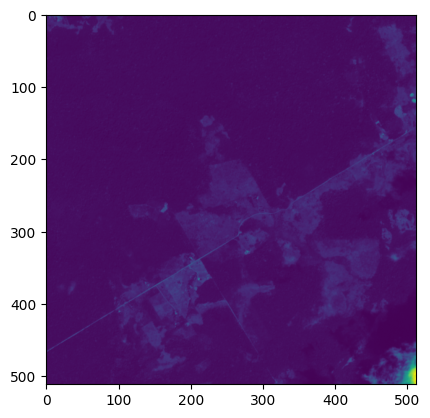

In [17]:
# Show example train image
plt.imshow((np.array(rxr.open_rasterio(r"{}Training/image/{}".format(base_dir2,training_images_list2[20])))[0,:,:]))

In [18]:
# Pre-process data, reshaping and transposing
for i in range(len(training_images2)):
  training_images2[i] = training_images2[i].astype('float32')
  training_images2[i] = training_images2[i].T

for i in range(len(training_masks2)):
  training_masks2[i] = training_masks2[i].reshape(1,512,512,1)
  training_masks2[i] = training_masks2[i].T

for i in range(len(validation_images2)):
  validation_images2[i] = validation_images2[i].astype('float32')
  validation_images2[i] = validation_images2[i].T

for i in range(len(validation_masks2)):
  validation_masks2[i] = validation_masks2[i].reshape(1,512,512,1)
  validation_masks2[i] = validation_masks2[i].T

for i in range(len(test_images2)):
  test_images2[i] = test_images2[i].astype('float32')
  test_images2[i] = test_images2[i].T

for i in range(len(test_masks2)):
  test_masks2[i] = test_masks2[i].reshape(1,512,512,1)
  test_masks2[i] = test_masks2[i].T

for i in range(len(training_images2)):
  training_images2[i] = training_images2[i].reshape(-1,512,512,4)

for i in range(len(validation_images2)):
  validation_images2[i] = validation_images2[i].reshape(-1,512,512,4)

for i in range(len(test_images2)):
  test_images2[i] = test_images2[i].reshape(-1,512,512,4)

In [19]:
# Create TensorFlow datasets for training and validation sets
train_df_4band_amazon = tf.data.Dataset.from_tensor_slices((training_images2[0:250], training_masks2[0:250]))
validation_df_4band_amazon = tf.data.Dataset.from_tensor_slices((validation_images2, validation_masks2))

## 4-band Atlantic Forest dataset

In [20]:
download = True # True if files don't already exist in same directory
base_dir3 = r"./ATLANTIC FOREST/"

In [21]:
base_dir_atlantic = "./ATLANTIC FOREST/"

In [22]:
# Ingest images and normalise

## Training images
training_images_list3 = os.listdir(r"{}Training/image/".format(base_dir3))[0:250]
training_masks_list3 = []
training_images3 = []
for n in training_images_list3:
  training_masks_list3.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Training/image/{}".format(base_dir3,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  training_images3.append(a)

## Training masks
training_masks3 = []
for n in training_masks_list3:
  a = (np.array(rxr.open_rasterio(r"{}Training/label/{}".format(base_dir3,n))))
  training_masks3.append(a)

## Test images
test_images_list3 = os.listdir(r"{}Test/image/".format(base_dir3))
test_masks_list3 = []
test_images3 = []
for n in test_images_list3:
  test_masks_list3.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Test/image/{}".format(base_dir3,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  test_images3.append(a)

## Test masks
test_masks3 = []
for n in test_masks_list3:
  a = (np.array(rxr.open_rasterio(r"{}Test/mask/{}".format(base_dir3,n))))
  test_masks3.append(a)

## Validation images
validation_images_list3 = os.listdir(r"{}Validation/images/".format(base_dir3))
validation_masks_list3 = []
validation_images3 = []
for n in validation_images_list3:
  validation_masks_list3.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Validation/images/{}".format(base_dir3,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  validation_images3.append(a)

## Validation masks
validation_masks3 = []
for n in validation_masks_list3:
  a = (np.array(rxr.open_rasterio(r"{}Validation/masks/{}".format(base_dir3,n))))
  validation_masks3.append(a)

In [23]:
# Pre-process data, reshaping and transposing
for i in range(len(training_images3)):
  training_images3[i] = training_images3[i].astype('float32')
  training_images3[i] = training_images3[i].T

for i in range(len(training_masks3)):
  training_masks3[i] = training_masks3[i].reshape(1,512,512,1)
  training_masks3[i] = training_masks3[i].T

for i in range(len(validation_images3)):
  validation_images3[i] = validation_images3[i].astype('float32')
  validation_images3[i] = validation_images3[i].T

for i in range(len(validation_masks3)):
  validation_masks3[i] = validation_masks3[i].reshape(1,512,512,1)
  validation_masks3[i] = validation_masks3[i].T

for i in range(len(test_images3)):
  test_images3[i] = test_images3[i].astype('float32')
  test_images3[i] = test_images3[i].T

for i in range(len(test_masks3)):
  test_masks3[i] = test_masks3[i].reshape(1,512,512,1)
  test_masks3[i] = test_masks3[i].T


for i in range(len(training_images3)):
  training_images3[i] = training_images3[i].reshape(-1,512,512,4)

for i in range(len(validation_images3)):
  validation_images3[i] = validation_images3[i].reshape(-1,512,512,4)

for i in range(len(test_images3)):
  test_images3[i] = test_images3[i].reshape(-1,512,512,4)

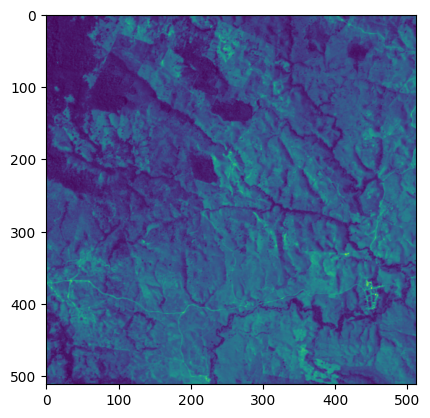

In [24]:
# Plot example training image first band
plt.imshow(training_images3[0].reshape(512,512,4)[:,:,0])

In [25]:
# Create TensorFlow datasets for training and validation sets
train_df_4band_atlantic = tf.data.Dataset.from_tensor_slices((training_images3[0:250], training_masks3[0:250]))
validation_df_4band_atlantic = tf.data.Dataset.from_tensor_slices((validation_images3, validation_masks3))

# Models

## U-Net

In [30]:

tf.keras.backend.clear_session()

try:
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print("Mixed precision enabled.")
except Exception as e:
    print(f"Mixed precision not enabled: {e}")
    pass

'''
  Convolutional block with set parameters and activation layer after
'''
def convBlock(x, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
    if transpose == False:
        conv = Conv2D(filters, kernel, padding='same', kernel_initializer=kernel_init)(x)
    else:
        conv = Conv2DTranspose(filters, kernel, padding='same', kernel_initializer=kernel_init)(x)

    conv = Activation(act)(conv)
    return conv

'''
  U-Net model
'''
def UNet(trained_weights=None, input_size=(512, 512, 3), drop_rate=0.25, lr=0.0001):

    # Input layer
    inputs = Input(input_size)

    ## Contraction phase (Encoder)
    conv1 = convBlock(inputs, 64, 3)
    conv1 = convBlock(conv1, 64, 3)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = convBlock(pool1, 128, 3)
    conv2 = convBlock(conv2, 128, 3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    # drop2 = Dropout(drop_rate)(pool2)

    conv3 = convBlock(pool2, 256, 3)
    conv3 = convBlock(conv3, 256, 3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # drop3 = Dropout(drop_rate)(pool3)

    conv4 = convBlock(pool3, 512, 3)
    conv4 = convBlock(conv4, 512, 3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    # drop4 = Dropout(drop_rate)(pool4)

    # Bottleneck
    conv5 = convBlock(pool4, 1024, 3)
    conv5 = convBlock(conv5, 1024, 3)

    ## Expansion phase (Decoder)
    up6 = Conv2DTranspose(512, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5)
    merge6 = concatenate([conv4, up6])
    conv6 = convBlock(merge6, 512, 3)
    conv6 = convBlock(conv6, 512, 3)

    up7 = Conv2DTranspose(256, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6)
    merge7 = concatenate([conv3, up7])
    conv7 = convBlock(merge7, 256, 3)
    conv7 = convBlock(conv7, 256, 3)

    up8 = Conv2DTranspose(128, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv7)
    merge8 = concatenate([conv2, up8])
    conv8 = convBlock(merge8, 128, 3)
    conv8 = convBlock(conv8, 128, 3)

    up9 = Conv2DTranspose(64, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv8)
    merge9 = concatenate([conv1, up9])
    conv9 = convBlock(merge9, 64, 3)
    conv9 = convBlock(conv9, 64, 3)

    # Output layer
    conv10 = Conv2D(1, 1, padding='same', kernel_initializer='he_normal')(conv9)
    outputs = Activation('sigmoid', dtype='float32', name='predictions')(conv10)

    model = Model(inputs, outputs)

    # Compile
    model.compile(optimizer=Adam(learning_rate=lr), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy', 'mse'])

    if trained_weights is not None:
        model.load_weights(trained_weights)

    return model

Mixed precision enabled.


In [31]:
model_unet = UNet(input_size=(512,512,3), lr=0.0001)
model_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 512, 512, 64  0           ['conv2d[0][0]']                 
                                )                                                             

## Attention U-Net

In [32]:

tf.keras.backend.clear_session()
try:
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print("Mixed precision enabled (float16 compute, float32 variables).")
except Exception as e:
    print(f"Mixed precision setup failed: {e}")

def convBlock(x, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
    if transpose == False:
        conv = Conv2D(filters, kernel, padding='same', kernel_initializer=kernel_init)(x)
    else:
        conv = Conv2DTranspose(filters, kernel, padding='same', kernel_initializer=kernel_init)(x)
    conv = Activation(act)(conv)
    return conv

def convBlock2(x, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
    if transpose == False:
        conv = Conv2D(filters, kernel, padding='same', kernel_initializer=kernel_init)(x)
        conv = Activation(act)(conv)
        conv = Conv2D(filters, kernel, padding='same', kernel_initializer=kernel_init)(conv)
        conv = Activation(act)(conv)
    else:
        conv = Conv2DTranspose(filters, kernel, padding='same', kernel_initializer=kernel_init)(x)
        conv = Activation(act)(conv)
        conv = Conv2DTranspose(filters, kernel, padding='same', kernel_initializer=kernel_init)(conv)
        conv = Activation(act)(conv)
    return conv

def attention_block(x, gating, inter_shape, drop_rate=0.25):
    
    
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    phi_g = Conv2D(inter_shape, (1, 1), padding='same', kernel_initializer='he_normal')(gating)
    theta_x = Conv2D(inter_shape, (1, 1), padding='same', kernel_initializer='he_normal')(x)
    theta_x = MaxPooling2D(pool_size=(2, 2))(theta_x)

    concat_xg = add([phi_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    psi = Conv2D(1, (1, 1), padding='same', kernel_initializer='he_normal')(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_g[1], shape_x[2] // shape_g[2]))(sigmoid_xg)
    
    y = multiply([upsample_psi, x])
    
    return y


def UNetAM(trained_weights=None, input_size=(512, 512, 3), drop_rate=0.25, lr=0.0001, filter_base=16):
    
    # Input layer
    inputs = Input(input_size)

    ## --- Encoder (Contraction) ---
    conv = convBlock2(inputs, filter_base, 3)
    conv0 = MaxPooling2D(pool_size=(2, 2))(conv)
    
    conv0 = convBlock2(conv0, 2 * filter_base, 3)
    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)
    
    conv1 = convBlock2(pool0, 4 * filter_base, 3)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = convBlock2(pool1, 8 * filter_base, 3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Bottleneck
    conv3 = convBlock2(pool2, 16 * filter_base, 3)
    
    # Block 4
    up4 = Conv2DTranspose(8 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv3)
    merge4 = attention_block(conv2, conv3, 8 * filter_base, drop_rate) 
    conv4 = concatenate([up4, merge4])
    conv4 = convBlock2(conv4, 8 * filter_base, 3)

    # Block 5
    up5 = Conv2DTranspose(4 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv4)
    merge5 = attention_block(conv1, conv4, 4 * filter_base, drop_rate) 
    conv5 = concatenate([up5, merge5])
    conv5 = convBlock2(conv5, 4 * filter_base, 3)

    # Block 6
    up6 = Conv2DTranspose(2 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5)
    merge6 = attention_block(conv0, conv5, 2 * filter_base, drop_rate) 
    conv6 = concatenate([up6, merge6])
    conv6 = convBlock2(conv6, 2 * filter_base, 3)

    # Block 7
    up7 = Conv2DTranspose(1 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6)
    merge7 = attention_block(conv, conv6, 1 * filter_base, drop_rate)
    conv7 = concatenate([up7, merge7])
    conv7 = convBlock2(conv7, 1 * filter_base, 3)

    # --- Output Layer ---
    conv_final = Conv2D(1, 1, padding='same', kernel_initializer='he_normal')(conv7)
    
    out = Activation('sigmoid', dtype='float32', name='output_sigmoid')(conv_final)

    model = Model(inputs, out)

    model.compile(optimizer=Adam(learning_rate=lr), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy', 'mse'])

    if trained_weights is not None:
        model.load_weights(trained_weights)

    return model

Mixed precision enabled (float16 compute, float32 variables).


In [33]:
UNetAM().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 512, 512, 16  0           ['conv2d[0][0]']                 
                                )                                                             

## ResNet50-SegNet

In [34]:

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print("Mixed precision policy set to:", policy.name)

class MaxPoolingWithArgmax2D(Layer):
    def __init__(self, pool_size=(2, 2), strides=(2, 2), padding="same", **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        
        ksize = [1, pool_size[0], pool_size[1], 1]
        padding = padding.upper()
        strides = [1, strides[0], strides[1], 1]
        
        output, argmax = tf.nn.max_pool_with_argmax(
            inputs, ksize=ksize, strides=strides, padding=padding
        )

        argmax = K.cast(argmax, 'float32') 
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        ratio = (1, 2, 2, 1)
        output_shape = [
            dim // ratio[i] if dim is not None else None
            for i, dim in enumerate(input_shape)
        ]
        return output_shape, output_shape

class MaxUnpooling2D(Layer):
    def __init__(self, size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.size = size

    def call(self, inputs, output_shape=None):
        updates, mask = inputs[0], inputs[1]
        
        mask = K.cast(mask, "int32")
        input_shape = tf.shape(updates, out_type="int32")
        
        if output_shape is None:
            output_shape = (
                input_shape[0],
                input_shape[1] * self.size[0],
                input_shape[2] * self.size[1],
                input_shape[3],
            )
        self.output_shape1 = output_shape

        one_like_mask = K.ones_like(mask, dtype="int32")
        batch_shape = K.concatenate([[input_shape[0]], [1], [1], [1]], axis=0)
        batch_range = K.reshape(
            tf.range(output_shape[0], dtype="int32"), shape=batch_shape
        )
        b = one_like_mask * batch_range
        y = mask // (output_shape[2] * output_shape[3])
        x = (mask // output_shape[3]) % output_shape[2]
        feature_range = tf.range(output_shape[3], dtype="int32")
        f = one_like_mask * feature_range

        updates_size = tf.size(updates)
        indices = K.transpose(K.reshape(K.stack([b, y, x, f]), [4, updates_size]))
        values = K.reshape(updates, [updates_size])
        ret = tf.scatter_nd(indices, values, output_shape)
        return ret

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
            mask_shape[0],
            mask_shape[1] * self.size[0],
            mask_shape[2] * self.size[1],
            mask_shape[3],
        )

def resnetConvDownBlock(x, filter, kernel, act='relu'):
    for i in range(2): 
        x = ZeroPadding2D((1,1))(x) 
        x = Conv2D(filters = filter, kernel_size = kernel, kernel_initializer = 'he_normal')(x)
        x = Activation('relu')(x)
    return x

def resnetConvUpBlock(x, skip_connection = None, filter = None, kernel = None, act='relu'):
    out = x
    out = UpSampling2D((2,2))(out)

    for i in range(2):
        out = ZeroPadding2D((1,1))(out)
        out = Conv2D(filters = filter, kernel_size = kernel, kernel_initializer = 'he_normal')(out)
        out = Activation('relu')(out)

    if skip_connection != None:
        out = Add()([out, skip_connection])

    return out

def ResNet50SegNet(input_size=(512,512,3), lr = 0.0001, filters = 16, kernel_sz = 3):
    
    inputs = Input(input_size)

    # --- Encoder ---
    block1 = resnetConvDownBlock(inputs, filter = filters, kernel = kernel_sz)
    pool1, mask1 = MaxPoolingWithArgmax2D((2,2))(block1)
    
    block2 = resnetConvDownBlock(pool1, filter = 2 * filters, kernel = kernel_sz)
    pool2, mask2 = MaxPoolingWithArgmax2D((2,2))(block2)
    
    block3 = resnetConvDownBlock(pool2, filter = 4 * filters, kernel = kernel_sz)
    pool3, mask3 = MaxPoolingWithArgmax2D((2,2))(block3)
    
    block4 = resnetConvDownBlock(pool3, filter = 8 * filters, kernel = kernel_sz)
    pool4, mask4 = MaxPoolingWithArgmax2D((2,2))(block4)
    
    block5 = resnetConvDownBlock(pool4, filter = 16 * filters, kernel = kernel_sz)
    pool5, mask5 = MaxPoolingWithArgmax2D((2,2))(block5)

    # --- Decoder ---
    block5_ = resnetConvUpBlock(pool5, filter = 16 * filters, kernel = kernel_sz)
    
    skip4 = MaxUnpooling2D((2,2))([pool4, mask4])
    block4_ = resnetConvUpBlock(block5_, skip_connection = skip4, filter = 8 * filters, kernel = kernel_sz)
    
    skip3 = MaxUnpooling2D((2,2))([pool3, mask3])
    block3_ = resnetConvUpBlock(block4_, skip_connection = skip3, filter = 4 * filters, kernel = kernel_sz)
    
    skip2 = MaxUnpooling2D((2,2))([pool2, mask2])
    block2_ = resnetConvUpBlock(block3_, skip_connection = skip2, filter = 2 * filters, kernel = kernel_sz)
    
    skip1 = MaxUnpooling2D((2,2))([pool1, mask1])
    block1_ = resnetConvUpBlock(block2_, skip_connection = skip1, filter = filters, kernel = kernel_sz)
    
    # Output
    outputs = Conv2D(1, kernel_size = 1, strides = 1, kernel_initializer = 'he_normal', dtype='float32')(block1_)
    outputs = Activation('sigmoid', dtype='float32')(outputs)

    model = Model(inputs, outputs)
    
    model.compile(optimizer = Adam(learning_rate = lr), 
                  loss = 'binary_crossentropy', 
                  metrics = ['accuracy', 'mse'])

    return model

Mixed precision policy set to: mixed_float16


In [35]:
ResNet50SegNet().summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 514, 514, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv2d_31 (Conv2D)             (None, 512, 512, 16  448         ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

## FCN32-VGG16

In [36]:

tf.keras.backend.clear_session()

mixed_precision.set_global_policy('mixed_float16')

def vgg_block(x, filters, num_convs=2, block_name='block'):
    for i in range(num_convs):
        name = f'{block_name}_conv{i+1}'
        x = Conv2D(filters, (3, 3), padding='same', name=name)(x)
        x = BatchNormalization()(x) 
        x = Activation('relu')(x)
    
    name_pool = f'{block_name}_pool'
    x = MaxPooling2D((2, 2), strides=(2, 2), name=name_pool)(x)
    return x

def fcn_32(input_size=(512,512,3), lr=0.0001, drop_rate=0.3):

    base_filters = 32 
    
    inputs = Input(shape=input_size)
    x = inputs

    # --- Encoder ---
    # Block 1: 32
    x = vgg_block(x, base_filters, num_convs=2, block_name='block1')
    # Block 2: 64
    x = vgg_block(x, base_filters * 2, num_convs=2, block_name='block2')
    # Block 3: 128
    x = vgg_block(x, base_filters * 4, num_convs=2, block_name='block3')
    # Block 4: 256
    x = vgg_block(x, base_filters * 8, num_convs=2, block_name='block4')
    # Block 5: 256 
    x = vgg_block(x, base_filters * 8, num_convs=2, block_name='block5')

    # --- "Dense" Layers (Converted to Conv) ---
    
    # "fc6" -> conv6 (7x7)
    x = Conv2D(2048, (7, 7), padding='same', name="conv6")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(drop_rate)(x)
    
    # "fc7" -> conv7 (1x1)
    x = Conv2D(2048, (1, 1), padding='same', name="conv7")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(drop_rate)(x)

    # --- Decoder ---
    
    # Score layer 
    score = Conv2D(1, (1, 1), padding='same', kernel_initializer='he_normal', name="score_fr")(x)
    
    # Upsample (32x)
    outputs = Conv2DTranspose(1, kernel_size=(64,64), strides=(32,32), 
                              padding='same', use_bias=False, name="upsample_32")(score)
    
    # Output
    outputs = Activation('sigmoid', dtype='float32')(outputs)

    model = Model(inputs, outputs, name="fcn_32_custom_512")
    
    model.compile(optimizer = Adam(learning_rate = lr), 
                  loss = 'binary_crossentropy', 
                  metrics = ['accuracy', 'mse'])
    
    return model

In [37]:

fcn_32().summary()

Model: "fcn_32_custom_512"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 512, 512, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 512, 512, 32)      0         
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 512, 512, 32)     128       
 hNormalization)                                 

## ResUNet

In [38]:

tf.keras.backend.clear_session()
try:
    mixed_precision.set_global_policy('mixed_float16')
except:
    pass

def res_block_separable(x, num_filters, kernel_size, name):

    if isinstance(num_filters, int):
        num_filters = [num_filters, num_filters]
    elif len(num_filters) == 1:
        num_filters = [num_filters[0], num_filters[0]]

    x1 = SeparableConv2D(filters=num_filters[0], kernel_size=kernel_size, strides=1, 
                         padding='same', depth_multiplier=1, kernel_initializer='he_normal', name=name+'_sep1')(x)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    
    x1 = SeparableConv2D(filters=num_filters[1], kernel_size=kernel_size, strides=1, 
                         padding='same', depth_multiplier=1, kernel_initializer='he_normal', name=name+'_sep2')(x1)
    x1 = BatchNormalization()(x1)

    if x.shape[-1] != num_filters[-1]:
        shortcut = Conv2D(filters=num_filters[-1], kernel_size=1, strides=1, 
                          padding='same', kernel_initializer='he_normal', name=name+'_shortcut')(x)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = x

    x1 = Add()([shortcut, x1])
    x1 = Activation('relu')(x1)
    return x1

def upsample(x, target_size):
    return Lambda(lambda x: tf.image.resize(x, target_size, method='nearest'))(x)

def encoder(x, num_filters, kernel_size):
    encoder_output = []
    
    x = res_block_separable(x, [num_filters[0]], kernel_size, name='enc_L1')
    encoder_output.append(x)
    
    for i in range(1, len(num_filters)):
        x = MaxPooling2D(pool_size=(2, 2), name=f'enc_pool_{i}')(x)
        x = res_block_separable(x, [num_filters[i]], kernel_size, name=f'enc_L{i+1}')
        encoder_output.append(x)
        
    return encoder_output

def decoder(x, encoder_output, num_filters, kernel_size):
    for i in range(1, len(num_filters) + 1):
        target_shape = tf.keras.backend.int_shape(encoder_output[-i])[1:3]
        
        x = upsample(x, target_shape)
        x = Concatenate(axis=-1)([x, encoder_output[-i]])
        x = res_block_separable(x, [num_filters[-i]], kernel_size, name=f'dec_L{i}')
    return x

def res_unet(input_size=512, 
                  num_filters=[16, 32, 64, 128], 
                  kernel_size=3, 
                  num_channels=3, 
                  num_classes=1, 
                  lr=0.0001):
    
    inputs = Input(shape=[input_size, input_size, num_channels])

    enc_out = encoder(inputs, num_filters, kernel_size)

    x = MaxPooling2D(pool_size=(2, 2), name='bridge_pool')(enc_out[-1])
    bridge = res_block_separable(x, [num_filters[-1]*2], kernel_size, name='bridge')

    dec_out = decoder(bridge, enc_out, num_filters, kernel_size)

    output = Conv2D(num_classes, 1, strides=1, padding='same', name='output')(dec_out)
    output = Activation('sigmoid', dtype='float32')(output)

    model = Model(inputs, output, name=f'ResUnet_Lite_F{num_filters[0]}')
    
    model.compile(optimizer=Adam(learning_rate=lr), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    return model


In [39]:

res_unet(512, [16, 32, 64, 128], 3, 3, 1).summary()

Model: "ResUnet_Lite_F16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 enc_L1_sep1 (SeparableConv2D)  (None, 512, 512, 16  91          ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 16  64         ['enc_L1_sep1[0][0]']            
 alization)                     )                                                  

# Train on RGB feature data

## U-Net

In [33]:
# Train U-Net with generator
model_unet = UNet(input_size=(512,512,3), lr=0.0001)
save_model = ModelCheckpoint('unet-3d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)

model_unet.fit(train, steps_per_epoch=100, epochs=30, validation_data = validation_df, callbacks=[save_model])

Epoch 1/30
100/100 [==============================] - ETA: 0s - loss: 0.4948 - accuracy: 0.7529 - mse: 0.1664
Epoch 1: val_accuracy improved from -inf to 0.83397, saving model to unet-3d.hdf5
100/100 [==============================] - 19s 98ms/step - loss: 0.4948 - accuracy: 0.7529 - mse: 0.1664 - val_loss: 0.3918 - val_accuracy: 0.8340 - val_mse: 0.1200
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 0.2425 - accuracy: 0.9113 - mse: 0.0669
Epoch 2: val_accuracy improved from 0.83397 to 0.88061, saving model to unet-3d.hdf5
100/100 [==============================] - 10s 96ms/step - loss: 0.2425 - accuracy: 0.9113 - mse: 0.0669 - val_loss: 0.3217 - val_accuracy: 0.8806 - val_mse: 0.0942
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 0.2152 - accuracy: 0.9193 - mse: 0.0604
Epoch 3: val_accuracy improved from 0.88061 to 0.90696, saving model to unet-3d.hdf5
100/100 [==============================] - 10s 96ms/step - loss: 0.2152 - accuracy: 0.91

In [34]:
# Save model training history
np.save('unet-3d-history.npy',model_unet.history.history)

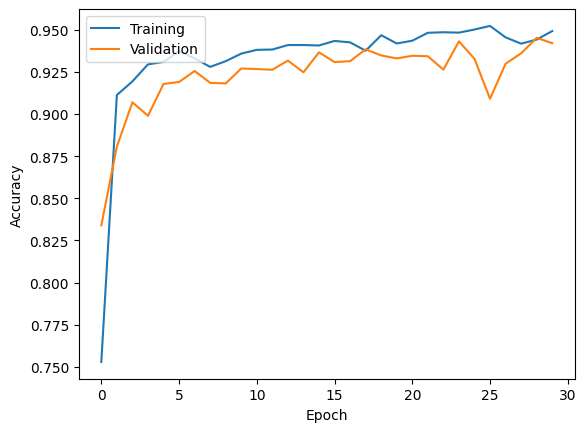

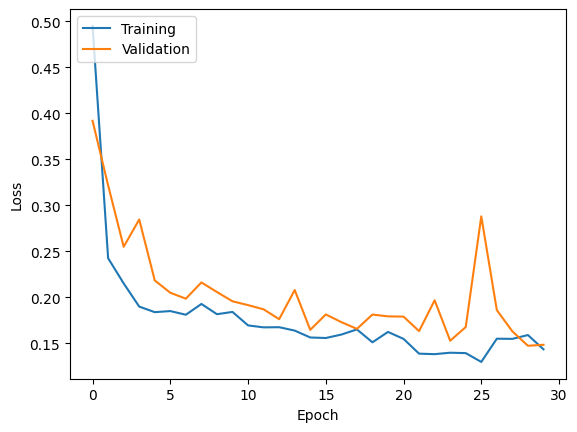

In [35]:
# Plot accuracy and loss 

## Accuracy
plt.plot(model_unet.history.history['accuracy'])
plt.plot(model_unet.history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(model_unet.history.history['loss'])
plt.plot(model_unet.history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

## Attention U-Net

In [45]:
# Train Attention U-Net with generator
model_attention_unet = UNetAM(lr=0.0005, filter_base=16)
save_model_am = ModelCheckpoint('unet-attention-3d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)
model_attention_unet.fit(train, steps_per_epoch=100, epochs=50, validation_data = validation_df, callbacks=[save_model_am])

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.4498 - accuracy: 0.8003 - mse: 0.1407
Epoch 1: val_accuracy improved from -inf to 0.90975, saving model to unet-attention-3d.hdf5
100/100 [==============================] - 6s 43ms/step - loss: 0.4498 - accuracy: 0.8003 - mse: 0.1407 - val_loss: 0.2593 - val_accuracy: 0.9097 - val_mse: 0.0729
Epoch 2/50
 99/100 [============================>.] - ETA: 0s - loss: 0.2575 - accuracy: 0.9108 - mse: 0.0707
Epoch 2: val_accuracy did not improve from 0.90975
100/100 [==============================] - 4s 37ms/step - loss: 0.2558 - accuracy: 0.9114 - mse: 0.0702 - val_loss: 0.2717 - val_accuracy: 0.8895 - val_mse: 0.0825
Epoch 3/50
 99/100 [============================>.] - ETA: 0s - loss: 0.2378 - accuracy: 0.9172 - mse: 0.0649
Epoch 3: val_accuracy did not improve from 0.90975
100/100 [==============================] - 4s 40ms/step - loss: 0.2367 - accuracy: 0.9178 - mse: 0.0646 - val_loss: 0.2547 - val_accuracy: 0.9049 - 

In [46]:
# Save model history
np.save('unet-attention-3d-history.npy',model_attention_unet.history.history)

## ResNet50-SegNet

In [67]:
R = ResNet50SegNet()
save_model_resnet = ModelCheckpoint('resnet50segnet-3d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True, save_weights_only=True)
train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)
R.fit(train, validation_data = validation_df, epochs = 40, steps_per_epoch = 100, callbacks=[save_model_resnet])

Epoch 1/40
 99/100 [============================>.] - ETA: 0s - loss: 0.6432 - accuracy: 0.6159 - mse: 0.2269
Epoch 1: val_accuracy improved from -inf to 0.77173, saving model to resnet50segnet-3d.hdf5
100/100 [==============================] - 6s 47ms/step - loss: 0.6440 - accuracy: 0.6116 - mse: 0.2274 - val_loss: 0.6275 - val_accuracy: 0.7717 - val_mse: 0.2179
Epoch 2/40
100/100 [==============================] - ETA: 0s - loss: 0.4892 - accuracy: 0.8257 - mse: 0.1448
Epoch 2: val_accuracy improved from 0.77173 to 0.85782, saving model to resnet50segnet-3d.hdf5
100/100 [==============================] - 4s 45ms/step - loss: 0.4892 - accuracy: 0.8257 - mse: 0.1448 - val_loss: 0.3418 - val_accuracy: 0.8578 - val_mse: 0.1049
Epoch 3/40
 99/100 [============================>.] - ETA: 0s - loss: 0.3688 - accuracy: 0.8568 - mse: 0.1087
Epoch 3: val_accuracy did not improve from 0.85782
100/100 [==============================] - 4s 44ms/step - loss: 0.3709 - accuracy: 0.8555 - mse: 0.1095 

In [68]:
# Save model history
np.save('resnet50segnet-3d-history.npy',R.history.history)

## FCN32-VGG16

In [69]:
F = fcn_32(lr = 0.0001)
save_model_fcn32 = ModelCheckpoint('fcn32-3d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)
F.fit(train, validation_data = validation_df, epochs=50, steps_per_epoch = 100, shuffle = True, callbacks=[save_model_fcn32])

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.6587 - accuracy: 0.5883 - mse: 0.2333
Epoch 1: val_accuracy improved from -inf to 0.49256, saving model to fcn32-3d.hdf5
100/100 [==============================] - 9s 57ms/step - loss: 0.6587 - accuracy: 0.5883 - mse: 0.2333 - val_loss: 0.7157 - val_accuracy: 0.4926 - val_mse: 0.2609
Epoch 2/50
 99/100 [============================>.] - ETA: 0s - loss: 0.5398 - accuracy: 0.7771 - mse: 0.1758
Epoch 2: val_accuracy improved from 0.49256 to 0.50779, saving model to fcn32-3d.hdf5
100/100 [==============================] - 5s 49ms/step - loss: 0.5391 - accuracy: 0.7785 - mse: 0.1755 - val_loss: 1.0133 - val_accuracy: 0.5078 - val_mse: 0.3536
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.4539 - accuracy: 0.8422 - mse: 0.1371
Epoch 3: val_accuracy did not improve from 0.50779
100/100 [==============================] - 5s 46ms/step - loss: 0.4539 - accuracy: 0.8422 - mse: 0.1371 - val_loss: 1.1145

In [70]:
# Save model history
np.save('fcn32-3d-history.npy', F.history.history)

## ResUNet

In [71]:
R = res_unet(512, [16, 32, 64, 128], 3, 3, 1)
save_model_resunet = ModelCheckpoint('resunet-3d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True, save_weights_only=True)
train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)
R.fit(train, validation_data = validation_df, epochs = 40, steps_per_epoch = 100, callbacks=[save_model_resunet])

Epoch 1/40
100/100 [==============================] - ETA: 0s - loss: 0.5623 - accuracy: 0.7236
Epoch 1: val_accuracy improved from -inf to 0.49261, saving model to resunet-3d.hdf5
100/100 [==============================] - 9s 55ms/step - loss: 0.5623 - accuracy: 0.7236 - val_loss: 0.7195 - val_accuracy: 0.4926
Epoch 2/40
100/100 [==============================] - ETA: 0s - loss: 0.4077 - accuracy: 0.8405
Epoch 2: val_accuracy improved from 0.49261 to 0.49774, saving model to resunet-3d.hdf5
100/100 [==============================] - 5s 49ms/step - loss: 0.4077 - accuracy: 0.8405 - val_loss: 0.6911 - val_accuracy: 0.4977
Epoch 3/40
100/100 [==============================] - ETA: 0s - loss: 0.3386 - accuracy: 0.8876
Epoch 3: val_accuracy improved from 0.49774 to 0.68397, saving model to resunet-3d.hdf5
100/100 [==============================] - 5s 49ms/step - loss: 0.3386 - accuracy: 0.8876 - val_loss: 0.6352 - val_accuracy: 0.6840
Epoch 4/40
 99/100 [============================>.] - E

In [72]:
# Save model history
np.save('resunet-3d-history.npy',R.history.history)

# Train on 4-band data

## Train on 4-band Amazon data

### U-Net

In [36]:
# Train U-Net with generator
model_unet_4band = UNet(input_size=(512, 512, 4))
save_model_4band = ModelCheckpoint('unet-4d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
model_unet_4band.fit(train_df_4band_amazon, epochs = 20, validation_data = validation_df_4band_amazon, callbacks=[save_model_4band])

Epoch 1/20
250/250 [==============================] - ETA: 0s - loss: 0.2581 - accuracy: 0.9002 - mse: 0.0772
Epoch 1: val_accuracy improved from -inf to 0.84156, saving model to unet-4d.hdf5
250/250 [==============================] - 27s 100ms/step - loss: 0.2581 - accuracy: 0.9002 - mse: 0.0772 - val_loss: 0.3445 - val_accuracy: 0.8416 - val_mse: 0.1053
Epoch 2/20
250/250 [==============================] - ETA: 0s - loss: 0.1847 - accuracy: 0.9339 - mse: 0.0523
Epoch 2: val_accuracy did not improve from 0.84156
250/250 [==============================] - 23s 94ms/step - loss: 0.1847 - accuracy: 0.9339 - mse: 0.0523 - val_loss: 0.4967 - val_accuracy: 0.7666 - val_mse: 0.1609
Epoch 3/20
250/250 [==============================] - ETA: 0s - loss: 0.1761 - accuracy: 0.9358 - mse: 0.0498
Epoch 3: val_accuracy did not improve from 0.84156
250/250 [==============================] - 23s 94ms/step - loss: 0.1761 - accuracy: 0.9358 - mse: 0.0498 - val_loss: 0.5068 - val_accuracy: 0.7875 - val_ms

In [37]:
# Save model history
np.save('unet-4d-history.npy',model_unet_4band.history.history)

### Attention U-Net

In [41]:
# Train U-Net with generator
model_attention_unet_4band = UNetAM(input_size=(512,512,4), filter_base=16, lr=0.0005)
save_model_4band_attention = ModelCheckpoint('unet-attention-4d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
model_attention_unet_4band.fit(train_df_4band_amazon, epochs = 60, validation_data = validation_df_4band_amazon, callbacks=[save_model_4band_attention])

Epoch 1/60
249/250 [============================>.] - ETA: 0s - loss: 0.2721 - accuracy: 0.8927 - mse: 0.0824
Epoch 1: val_accuracy improved from -inf to 0.78572, saving model to unet-attention-4d.hdf5
250/250 [==============================] - 10s 28ms/step - loss: 0.2747 - accuracy: 0.8917 - mse: 0.0832 - val_loss: 0.4790 - val_accuracy: 0.7857 - val_mse: 0.1530
Epoch 2/60
248/250 [============================>.] - ETA: 0s - loss: 0.1837 - accuracy: 0.9366 - mse: 0.0512
Epoch 2: val_accuracy did not improve from 0.78572
250/250 [==============================] - 6s 25ms/step - loss: 0.1905 - accuracy: 0.9348 - mse: 0.0528 - val_loss: 0.5714 - val_accuracy: 0.7744 - val_mse: 0.1694
Epoch 3/60
250/250 [==============================] - ETA: 0s - loss: 0.1802 - accuracy: 0.9366 - mse: 0.0498
Epoch 3: val_accuracy did not improve from 0.78572
250/250 [==============================] - 6s 25ms/step - loss: 0.1802 - accuracy: 0.9366 - mse: 0.0498 - val_loss: 0.5566 - val_accuracy: 0.7773 -

In [42]:
# Save model history
np.save('unet-attention-4d-history.npy',model_attention_unet_4band.history.history)

### ResNet50-SegNet

In [ ]:
R_4band = ResNet50SegNet(input_size=(512,512,4))
save_model_resnet_4band = ModelCheckpoint('resnet50segnet-4d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True, save_weights_only=True)
R_4band.fit(train_df_4band_amazon, validation_data = validation_df_4band_amazon, epochs = 20, callbacks=[save_model_resnet_4band])

Epoch 1/20
249/250 [============================>.] - ETA: 0s - loss: 0.6528 - accuracy: 0.6198 - mse: 0.2297
Epoch 1: val_accuracy improved from -inf to 0.48341, saving model to resnet50segnet-4d.hdf5
250/250 [==============================] - 10s 33ms/step - loss: 0.6530 - accuracy: 0.6193 - mse: 0.2298 - val_loss: 0.6937 - val_accuracy: 0.4834 - val_mse: 0.2503
Epoch 2/20
249/250 [============================>.] - ETA: 0s - loss: 0.6707 - accuracy: 0.5558 - mse: 0.2380
Epoch 2: val_accuracy improved from 0.48341 to 0.52159, saving model to resnet50segnet-4d.hdf5
250/250 [==============================] - 8s 30ms/step - loss: 0.6708 - accuracy: 0.5550 - mse: 0.2381 - val_loss: 0.6938 - val_accuracy: 0.5216 - val_mse: 0.2503
Epoch 3/20
250/250 [==============================] - ETA: 0s - loss: 0.6896 - accuracy: 0.5873 - mse: 0.2414
Epoch 3: val_accuracy improved from 0.52159 to 0.52162, saving model to resnet50segnet-4d.hdf5
250/250 [==============================] - 8s 30ms/step - l

In [58]:
# Save model history
np.save('resnet50segnet-4d-history.npy', R_4band.history.history)

### FCN32-VGG16

In [73]:
F_4band = fcn_32(input_size=(512,512,4), lr = 0.0001)
save_model_fcn_4band = ModelCheckpoint('fcn32-4d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
F_4band.fit(train_df_4band_amazon, validation_data = validation_df_4band_amazon, epochs = 50, callbacks=[save_model_fcn_4band])

Epoch 1/50
250/250 [==============================] - ETA: 0s - loss: 0.5885 - accuracy: 0.6976 - mse: 0.2002
Epoch 1: val_accuracy improved from -inf to 0.69195, saving model to fcn32-4d.hdf5
250/250 [==============================] - 14s 49ms/step - loss: 0.5885 - accuracy: 0.6976 - mse: 0.2002 - val_loss: 0.6265 - val_accuracy: 0.6919 - val_mse: 0.2124
Epoch 2/50
249/250 [============================>.] - ETA: 0s - loss: 0.4299 - accuracy: 0.8414 - mse: 0.1291
Epoch 2: val_accuracy improved from 0.69195 to 0.87705, saving model to fcn32-4d.hdf5
250/250 [==============================] - 11s 42ms/step - loss: 0.4295 - accuracy: 0.8416 - mse: 0.1290 - val_loss: 0.3459 - val_accuracy: 0.8771 - val_mse: 0.1030
Epoch 3/50
249/250 [============================>.] - ETA: 0s - loss: 0.3599 - accuracy: 0.8679 - mse: 0.1032
Epoch 3: val_accuracy improved from 0.87705 to 0.89059, saving model to fcn32-4d.hdf5
250/250 [==============================] - 11s 44ms/step - loss: 0.3596 - accuracy: 0

In [74]:
# Save model history
np.save('fcn32-4d-history.npy', F_4band.history.history)

### ResUNet

In [75]:
R_4band = res_unet(512, [16, 32, 64, 128], 3, 4, 1)
save_model_resunet_4band = ModelCheckpoint('resunet-4d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True, save_weights_only=True)
R_4band.fit(train_df_4band_amazon, validation_data = validation_df_4band_amazon, epochs = 20, callbacks=[save_model_resunet_4band])

Epoch 1/20
250/250 [==============================] - ETA: 0s - loss: 0.5458 - accuracy: 0.7348
Epoch 1: val_accuracy improved from -inf to 0.52192, saving model to resunet-4d.hdf5
250/250 [==============================] - 19s 54ms/step - loss: 0.5458 - accuracy: 0.7348 - val_loss: 0.6970 - val_accuracy: 0.5219
Epoch 2/20
250/250 [==============================] - ETA: 0s - loss: 0.3771 - accuracy: 0.8531
Epoch 2: val_accuracy improved from 0.52192 to 0.89303, saving model to resunet-4d.hdf5
250/250 [==============================] - 13s 52ms/step - loss: 0.3771 - accuracy: 0.8531 - val_loss: 0.4408 - val_accuracy: 0.8930
Epoch 3/20
249/250 [============================>.] - ETA: 0s - loss: 0.3174 - accuracy: 0.8871
Epoch 3: val_accuracy did not improve from 0.89303
250/250 [==============================] - 13s 53ms/step - loss: 0.3172 - accuracy: 0.8873 - val_loss: 0.3253 - val_accuracy: 0.8683
Epoch 4/20
249/250 [============================>.] - ETA: 0s - loss: 0.2704 - accuracy: 

In [76]:
# Save model history
np.save('resunet-4d-history.npy', R_4band.history.history)

## Train on 4-band Atlantic data

### U-Net

In [47]:
# Train U-Net with generator
model_unet_4band_atlantic = UNet(input_size=(512, 512, 4))
save_model_4band_atlantic = ModelCheckpoint('unet-4d-atlantic.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
model_unet_4band_atlantic.fit(train_df_4band_atlantic, epochs = 20, validation_data = validation_df_4band_atlantic, callbacks=[save_model_4band_atlantic])

Epoch 1/20
250/250 [==============================] - ETA: 0s - loss: 0.2819 - accuracy: 0.8693 - mse: 0.0893
Epoch 1: val_accuracy improved from -inf to 0.86488, saving model to unet-4d-atlantic.hdf5
250/250 [==============================] - 26s 98ms/step - loss: 0.2819 - accuracy: 0.8693 - mse: 0.0893 - val_loss: 0.5128 - val_accuracy: 0.8649 - val_mse: 0.1116
Epoch 2/20
250/250 [==============================] - ETA: 0s - loss: 0.1779 - accuracy: 0.9281 - mse: 0.0533
Epoch 2: val_accuracy improved from 0.86488 to 0.87349, saving model to unet-4d-atlantic.hdf5
250/250 [==============================] - 24s 98ms/step - loss: 0.1779 - accuracy: 0.9281 - mse: 0.0533 - val_loss: 0.5971 - val_accuracy: 0.8735 - val_mse: 0.1088
Epoch 3/20
250/250 [==============================] - ETA: 0s - loss: 0.1670 - accuracy: 0.9325 - mse: 0.0500
Epoch 3: val_accuracy improved from 0.87349 to 0.87576, saving model to unet-4d-atlantic.hdf5
250/250 [==============================] - 24s 96ms/step - lo

In [48]:
# Save model history
np.save('unet-4d-atlantic-history.npy',model_unet_4band_atlantic.history.history)

### Attention U-Net

In [43]:
# Train Attention U-Net with generator
model_attention_unet_4band_atlantic = UNetAM(input_size=(512,512,4), filter_base=16, lr=0.0005)
save_model_4band_attention_atlantic = ModelCheckpoint('unet-attention-4d-atlantic.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
model_attention_unet_4band_atlantic.fit(train_df_4band_atlantic, epochs = 60, validation_data = validation_df_4band_atlantic, callbacks=[save_model_4band_attention_atlantic])

Epoch 1/60
250/250 [==============================] - ETA: 0s - loss: 0.3720 - accuracy: 0.8330 - mse: 0.1163
Epoch 1: val_accuracy improved from -inf to 0.86991, saving model to unet-attention-4d-atlantic.hdf5
250/250 [==============================] - 10s 32ms/step - loss: 0.3720 - accuracy: 0.8330 - mse: 0.1163 - val_loss: 0.5908 - val_accuracy: 0.8699 - val_mse: 0.1114
Epoch 2/60
250/250 [==============================] - ETA: 0s - loss: 0.1967 - accuracy: 0.9191 - mse: 0.0599
Epoch 2: val_accuracy improved from 0.86991 to 0.87585, saving model to unet-attention-4d-atlantic.hdf5
250/250 [==============================] - 6s 26ms/step - loss: 0.1967 - accuracy: 0.9191 - mse: 0.0599 - val_loss: 0.4934 - val_accuracy: 0.8759 - val_mse: 0.1049
Epoch 3/60
248/250 [============================>.] - ETA: 0s - loss: 0.1788 - accuracy: 0.9270 - mse: 0.0544
Epoch 3: val_accuracy improved from 0.87585 to 0.88065, saving model to unet-attention-4d-atlantic.hdf5
250/250 [=======================

In [44]:
# Save model history
np.save('unet-attention-4d-atlantic-history.npy',model_attention_unet_4band_atlantic.history.history)

### ResNet50-SegNet

In [77]:
R_4band_atlantic = ResNet50SegNet(input_size=(512,512,4))
save_model_resnet_4band_atlantic = ModelCheckpoint('resnet50segnet-4d-atlantic.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True, save_weights_only=True)
R_4band_atlantic.fit(train_df_4band_atlantic, validation_data = validation_df_4band_atlantic, epochs = 30, callbacks=[save_model_resnet_4band_atlantic])

Epoch 1/30
248/250 [============================>.] - ETA: 0s - loss: 0.5501 - accuracy: 0.7461 - mse: 0.1793
Epoch 1: val_accuracy improved from -inf to 0.74114, saving model to resnet50segnet-4d-atlantic.hdf5
250/250 [==============================] - 13s 40ms/step - loss: 0.5491 - accuracy: 0.7466 - mse: 0.1790 - val_loss: 0.6936 - val_accuracy: 0.7411 - val_mse: 0.1988
Epoch 2/30
250/250 [==============================] - ETA: 0s - loss: 0.3994 - accuracy: 0.8234 - mse: 0.1260
Epoch 2: val_accuracy improved from 0.74114 to 0.79201, saving model to resnet50segnet-4d-atlantic.hdf5
250/250 [==============================] - 9s 34ms/step - loss: 0.3994 - accuracy: 0.8234 - mse: 0.1260 - val_loss: 0.5720 - val_accuracy: 0.7920 - val_mse: 0.1610
Epoch 3/30
250/250 [==============================] - ETA: 0s - loss: 0.3602 - accuracy: 0.8426 - mse: 0.1127
Epoch 3: val_accuracy improved from 0.79201 to 0.80776, saving model to resnet50segnet-4d-atlantic.hdf5
250/250 [=======================

In [78]:
# Save model history
np.save('resnet50segnet-4d-history-atlantic.npy', R_4band_atlantic.history.history)

### FCN32-VGG16

In [79]:
F_4band_atlantic = fcn_32(input_size=(512,512,4), lr = 0.0001)
save_model_fcn32_4band_atlantic = ModelCheckpoint('fcn32-4d-atlantic.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
F_4band_atlantic.fit(train_df_4band_atlantic, validation_data = validation_df_4band_atlantic, epochs = 50, callbacks=[save_model_fcn32_4band_atlantic])

Epoch 1/50
249/250 [============================>.] - ETA: 0s - loss: 0.6049 - accuracy: 0.6700 - mse: 0.2081
Epoch 1: val_accuracy improved from -inf to 0.66177, saving model to fcn32-4d-atlantic.hdf5
250/250 [==============================] - 13s 44ms/step - loss: 0.6045 - accuracy: 0.6704 - mse: 0.2079 - val_loss: 0.7075 - val_accuracy: 0.6618 - val_mse: 0.2452
Epoch 2/50
249/250 [============================>.] - ETA: 0s - loss: 0.4870 - accuracy: 0.7841 - mse: 0.1564
Epoch 2: val_accuracy improved from 0.66177 to 0.79104, saving model to fcn32-4d-atlantic.hdf5
250/250 [==============================] - 11s 43ms/step - loss: 0.4868 - accuracy: 0.7842 - mse: 0.1564 - val_loss: 0.4646 - val_accuracy: 0.7910 - val_mse: 0.1484
Epoch 3/50
249/250 [============================>.] - ETA: 0s - loss: 0.4332 - accuracy: 0.8159 - mse: 0.1346
Epoch 3: val_accuracy did not improve from 0.79104
250/250 [==============================] - 10s 41ms/step - loss: 0.4331 - accuracy: 0.8160 - mse: 0.13

In [80]:
# Save model history
np.save('fcn32-4d-atlantic-history.npy', F_4band_atlantic.history.history)

### ResUNet

In [ ]:
R_4band_atlantic = res_unet(512, [16, 32, 64, 128], 3, 4, 1)
save_model_resunet_4band_atlantic = ModelCheckpoint('resunet-4d-atlantic.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True, save_weights_only=True)
R_4band_atlantic.fit(train_df_4band_atlantic, validation_data = validation_df_4band_atlantic, epochs = 30, callbacks=[save_model_resunet_4band_atlantic])

Epoch 1/30
250/250 [==============================] - ETA: 0s - loss: 0.6259 - accuracy: 0.6920
Epoch 1: val_accuracy improved from -inf to 0.65889, saving model to resunet-4d-atlantic.hdf5
250/250 [==============================] - 16s 52ms/step - loss: 0.6259 - accuracy: 0.6920 - val_loss: 0.6495 - val_accuracy: 0.6589
Epoch 2/30
250/250 [==============================] - ETA: 0s - loss: 0.3848 - accuracy: 0.8538
Epoch 2: val_accuracy improved from 0.65889 to 0.85773, saving model to resunet-4d-atlantic.hdf5
250/250 [==============================] - 13s 50ms/step - loss: 0.3848 - accuracy: 0.8538 - val_loss: 0.3789 - val_accuracy: 0.8577
Epoch 3/30
250/250 [==============================] - ETA: 0s - loss: 0.3319 - accuracy: 0.8778
Epoch 3: val_accuracy did not improve from 0.85773
250/250 [==============================] - 13s 50ms/step - loss: 0.3319 - accuracy: 0.8778 - val_loss: 0.4313 - val_accuracy: 0.8239
Epoch 4/30
249/250 [============================>.] - ETA: 0s - loss: 0

In [ ]:
# Save model history
np.save('resunet-4d-history-atlantic.npy', R_4band_atlantic.history.history)


# Import Models and Compute Metrics

## RGB

In [3]:
# Load 3-dim models and history stats
attention_unet = load_model('unet-attention-3d.hdf5')
unet = load_model('unet-3d.hdf5')

unet_history = np.load('unet-3d-history.npy', allow_pickle='TRUE').item()
attention_unet_history = np.load('unet-attention-3d-history.npy', allow_pickle='TRUE').item()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4060 Laptop GPU, compute capability 8.9


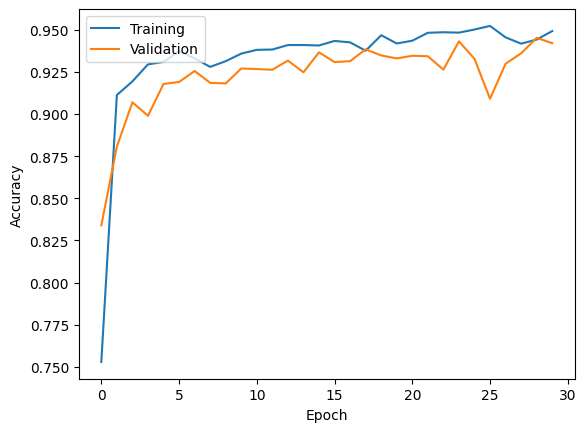

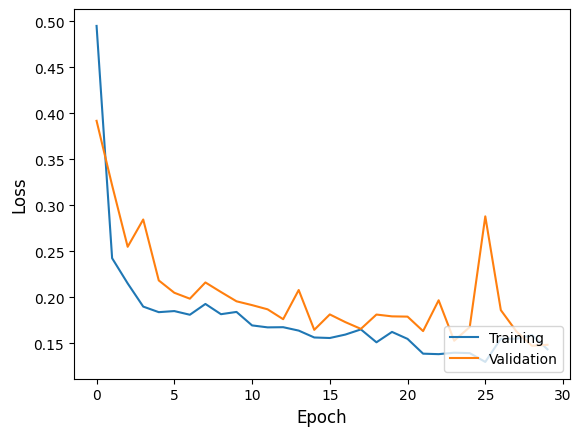

In [4]:
# Plot accuracy and loss for U-Net

## Accuracy
plt.plot(unet_history['accuracy'])
plt.plot(unet_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(unet_history['loss'])
plt.plot(unet_history['val_loss'])
plt.ylabel('Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.legend(['Training', 'Validation'], loc='lower right')

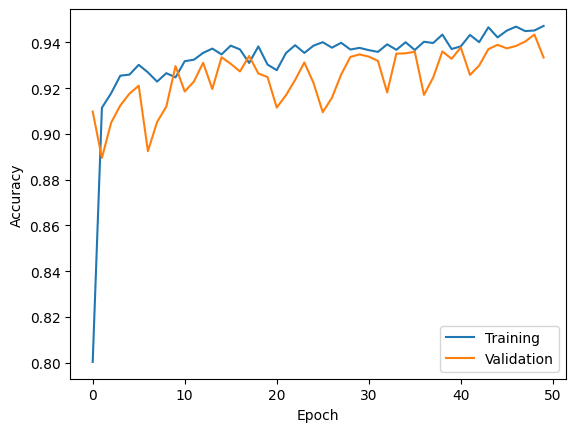

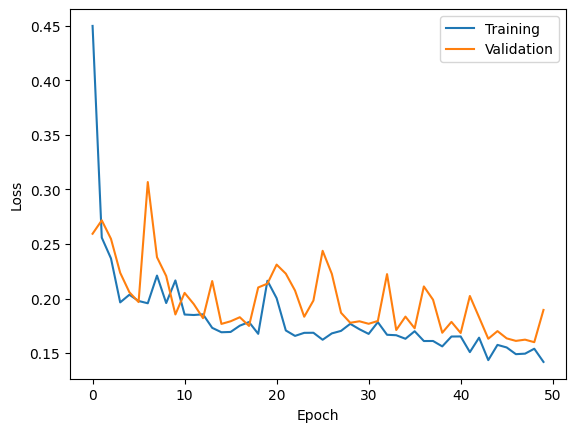

In [5]:
# Plot accuracy and loss for Attention U-Net

## Accuracy
plt.plot(attention_unet_history['accuracy'])
plt.plot(attention_unet_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

## Loss
plt.plot(attention_unet_history['loss'])
plt.plot(attention_unet_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

In [18]:
# Scores of each model
unet_score = (score_eval(unet, validation_images, validation_masks))
am_unet_score = (score_eval(attention_unet, validation_images, validation_masks))

1/1 [==============================] - 0s 18ms/step


In [ ]:

# Precision and recall of each model
unet_precision = (precision_eval(unet, validation_images, validation_masks))
am_unet_precision = (precision_eval(attention_unet, validation_images, validation_masks))

unet_recall = (recall_eval(unet, validation_images, validation_masks))
am_unet_recall = (recall_eval(attention_unet, validation_images, validation_masks))

1/1 [==============================] - 0s 19ms/step


In [55]:
# F1-scores of each model
unet_f1_score = (f1_score_eval_basic(unet_precision, unet_recall))
am_unet_f1_score = (f1_score_eval_basic(am_unet_precision, am_unet_recall))

In [56]:
# Print score eval results for each model
print('U-Net accuracy: ', np.mean(unet_score), np.std(unet_score))
print('Attention U-Net accuracy: ', np.mean(am_unet_score), np.std(am_unet_score))

U-Net accuracy:  0.9451700210571289 0.050286095101958965
Attention U-Net accuracy:  0.943423080444336 0.05274077921437196


In [57]:
# Print precision eval results for each model
print('U-Net precision: ', np.mean(unet_precision), np.std(unet_precision))
print('Attention U-Net precision: ', np.mean(am_unet_precision), np.std(am_unet_precision))

U-Net precision:  0.9538461089619508 0.038394720660915226
Attention U-Net precision:  0.9524463674727194 0.04051175735010528


In [58]:
# Print recall eval results for each model
print('U-Net recall: ', np.mean(unet_recall), np.std(unet_recall))
print('Attention U-Net recall: ', np.mean(am_unet_recall), np.std(am_unet_recall))

U-Net recall:  0.9451700210571289 0.050286095101958965
Attention U-Net recall:  0.943423080444336 0.05274077921437196


In [59]:
# Print f1-score eval results for each model
print('U-Net F1-score: ', np.mean(unet_f1_score))
print('Attention U-Net F1-score: ', np.mean(am_unet_f1_score))

U-Net F1-score:  0.9494882456672651
Attention U-Net F1-score:  0.9479132510377826


## 4-band

### Amazon Data

In [34]:
# Load 4-dim models and history stats
attention_unet_4d = load_model('unet-attention-4d.hdf5')
unet_4d = load_model('unet-4d.hdf5')

unet_4d_history = np.load('unet-4d-history.npy', allow_pickle='TRUE').item()
attention_unet_4d_history = np.load('unet-attention-4d-history.npy', allow_pickle='TRUE').item()

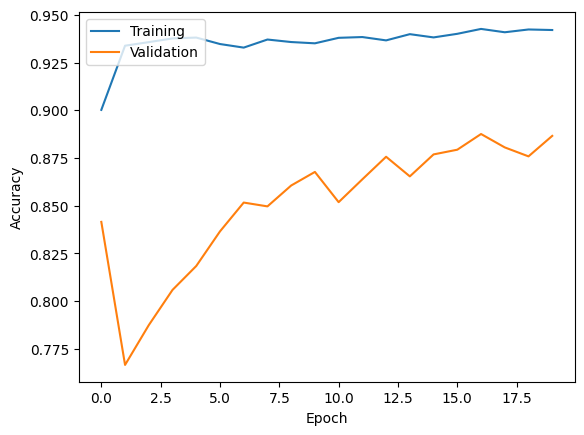

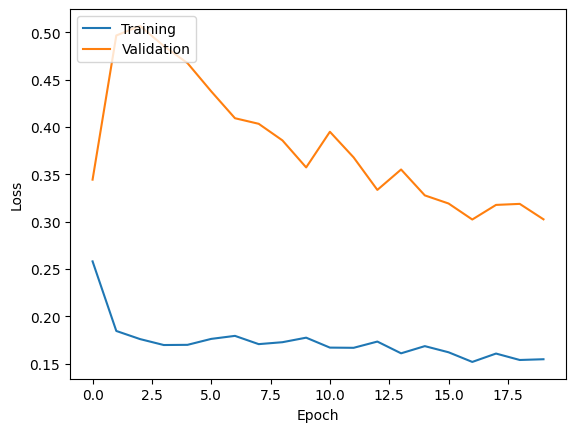

In [43]:
# Plot accuracy and loss for U-Net

## Accuracy
plt.plot(unet_4d_history['accuracy'])
plt.plot(unet_4d_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(unet_4d_history['loss'])
plt.plot(unet_4d_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

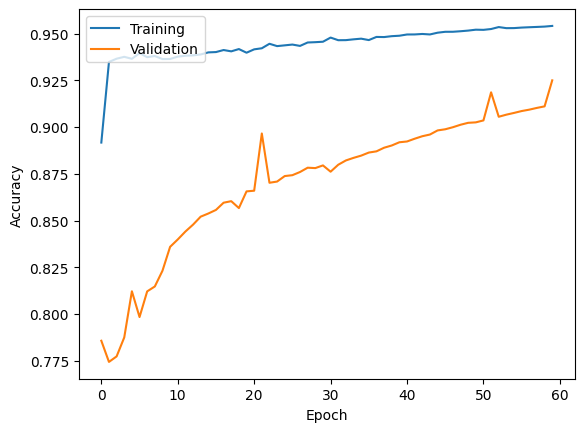

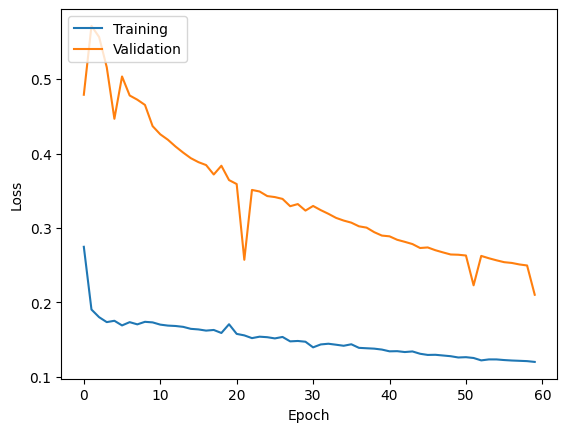

In [44]:
# Plot accuracy and loss for Attention U-Net

## Accuracy
plt.plot(attention_unet_4d_history['accuracy'])
plt.plot(attention_unet_4d_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(attention_unet_4d_history['loss'])
plt.plot(attention_unet_4d_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

In [63]:
# Scores of each model
unet_4d_score = (score_eval2(unet_4d, validation_images2, validation_masks2))
am_unet_4d_score = (score_eval2(attention_unet_4d, validation_images2, validation_masks2))

1/1 [==============================] - 0s 25ms/step


In [65]:
import gc

tf.keras.backend.clear_session()
gc.collect()

def evaluate_metrics_memory_efficient(model, images, masks):
    precisions = []
    recalls = []
    
    for i in range(len(images)):
        img = images[i]
        
        if img.ndim == 4:
            img_batch = img
        elif img.ndim == 3:
            img_batch = np.expand_dims(img, axis=0)
        else:
            img_batch = np.squeeze(img) 
            if img_batch.ndim == 3:
                img_batch = np.expand_dims(img_batch, axis=0)
            elif img_batch.ndim == 4:
                pass
            else:
                continue

        pred_batch = model.predict_on_batch(img_batch)
        
        
        y_pred = np.round(pred_batch).flatten()
        y_true = masks[i].flatten()
        
        p_score = precision_score(y_true, y_pred, average='binary', zero_division=0)
        r_score = recall_score(y_true, y_pred, average='binary', zero_division=0)
        
        precisions.append(p_score)
        recalls.append(r_score)
        
        del img_batch
        del pred_batch
        del y_pred
        del y_true
        
        if i % 10 == 0:
            gc.collect()
            print(f"Processing {i}/{len(images)}...", end='\r')
            
    return np.mean(precisions), np.mean(recalls)


print("--- Processing U-Net ---")
unet_4d_precision, unet_4d_recall = evaluate_metrics_memory_efficient(unet_4d, validation_images2, validation_masks2)

print(f"U-Net Precision: {unet_4d_precision:.4f}")
print(f"U-Net Recall:    {unet_4d_recall:.4f}")

print("\n--- Processing Attention U-Net ---")
tf.keras.backend.clear_session()
gc.collect()

am_unet_4d_precision, am_unet_4d_recall = evaluate_metrics_memory_efficient(attention_unet_4d, validation_images2, validation_masks2)

print(f"AM U-Net Precision: {am_unet_4d_precision:.4f}")
print(f"AM U-Net Recall:    {am_unet_4d_recall:.4f}")

--- Processing U-Net ---
U-Net Precision: 0.9695
U-Net Recall:    0.6907

--- Processing Attention U-Net ---
AM U-Net Precision: 0.9757
AM U-Net Recall:    0.7804


In [68]:
# F1-scores of each model
unet_4d_f1_score = (f1_score_eval_basic(unet_4d_precision, unet_4d_recall))
am_unet_4d_f1_score = (f1_score_eval_basic(am_unet_4d_precision, am_unet_4d_recall))

In [69]:
# Print score eval results for each model
print('U-Net accuracy: ', np.mean(unet_4d_score), np.std(unet_4d_score))
print('Attention U-Net accuracy: ', np.mean(am_unet_4d_score), np.std(am_unet_4d_score))

U-Net accuracy:  0.8876049423217773 0.09620901164475305
Attention U-Net accuracy:  0.9250068664550781 0.06595704039305535


In [70]:
# Print precision eval results for each model
print('U-Net precision: ', np.mean(unet_4d_precision), np.std(unet_4d_precision))
print('Attention U-Net precision: ', np.mean(am_unet_4d_precision), np.std(am_unet_4d_precision))

U-Net precision:  0.9695422554919255 0.0
Attention U-Net precision:  0.9757145604973283 0.0


In [71]:
# Print recall eval results for each model
print('U-Net recall: ', np.mean(unet_4d_recall), np.std(unet_4d_recall))
print('Attention U-Net recall: ', np.mean(am_unet_4d_recall), np.std(am_unet_4d_recall))

U-Net recall:  0.6906895570489674 0.0
Attention U-Net recall:  0.7803915860552638 0.0


In [72]:
# Print f1-score eval results for each model
print('U-Net F1-score: ', np.mean(unet_4d_f1_score))
print('Attention U-Net F1-score: ', np.mean(am_unet_4d_f1_score))

U-Net F1-score:  0.8066978429489414
Attention U-Net F1-score:  0.8671906705622603


### Atlantic Data

In [26]:
# Load 4-dim models and history stats
attention_unet_4d_atlantic = load_model('unet-attention-4d-atlantic.hdf5')
unet_4d_atlantic = load_model('unet-4d-atlantic.hdf5')

unet_4d_atlantic_history = np.load('unet-4d-atlantic-history.npy', allow_pickle='TRUE').item()
attention_unet_4d_atlantic_history = np.load('unet-attention-4d-atlantic-history.npy', allow_pickle='TRUE').item()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4060 Laptop GPU, compute capability 8.9


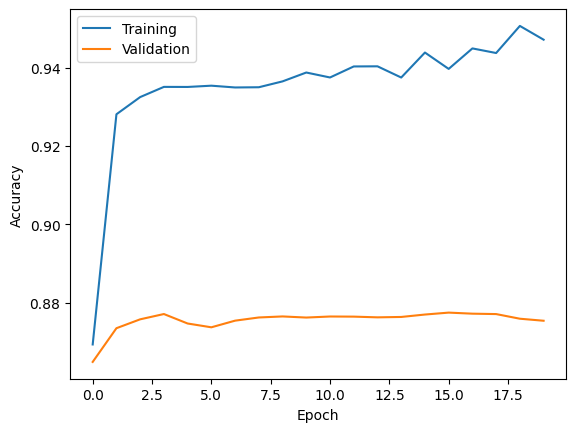

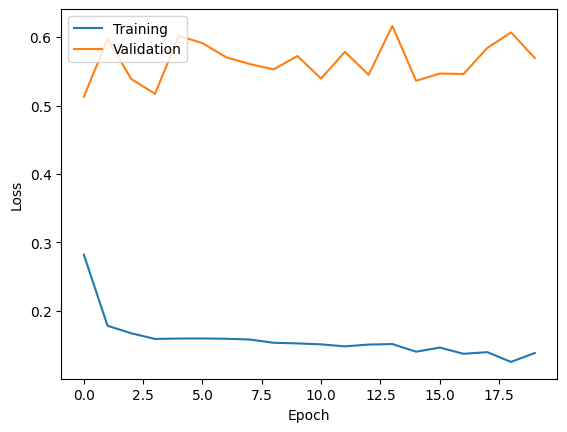

In [73]:
# Plot accuracy and loss for U-Net

## Accuracy
plt.plot(unet_4d_atlantic_history['accuracy'])
plt.plot(unet_4d_atlantic_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(unet_4d_atlantic_history['loss'])
plt.plot(unet_4d_atlantic_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

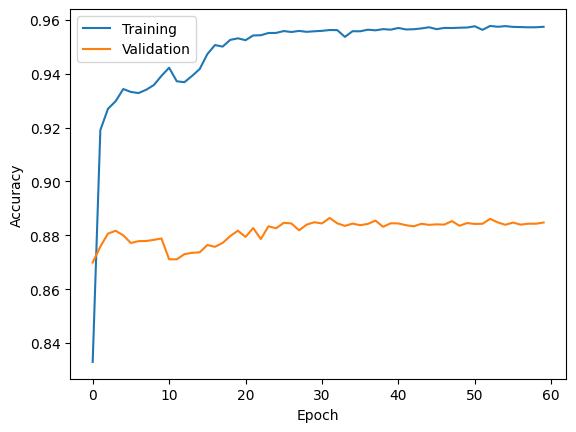

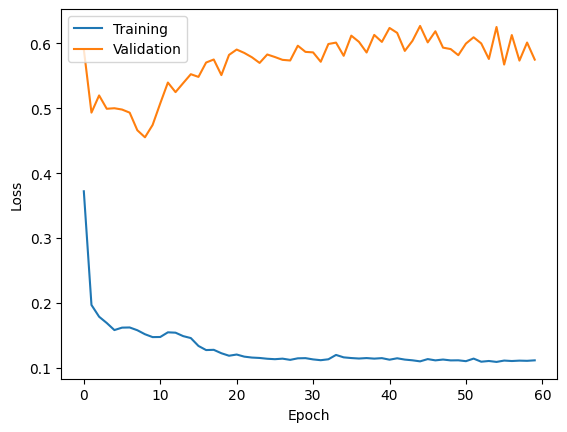

In [74]:
# Plot accuracy and loss for Attention U-Net

## Accuracy
plt.plot(attention_unet_4d_atlantic_history['accuracy'])
plt.plot(attention_unet_4d_atlantic_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(attention_unet_4d_atlantic_history['loss'])
plt.plot(attention_unet_4d_atlantic_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

In [27]:
def f1_score_calc(precision, recall):
    if (precision + recall) == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)

import numpy as np
import gc
from sklearn.metrics import precision_score, recall_score, accuracy_score

def evaluate_metrics_memory_efficient(model, images, masks):
    precisions = []
    recalls = []
    accuracies = [] 
    
    for i in range(len(images)):
        img = images[i]
        
        # --- Image Preprocessing Logic ---
        if img.ndim == 4:
            img_batch = img
        elif img.ndim == 3:
            img_batch = np.expand_dims(img, axis=0)
        else:
            img_batch = np.squeeze(img) 
            if img_batch.ndim == 3:
                img_batch = np.expand_dims(img_batch, axis=0)
            elif img_batch.ndim == 4:
                pass
            else:
                continue

        # --- Prediction ---
        pred_batch = model.predict_on_batch(img_batch)
        
        # --- Flattening ---
        y_pred = np.round(pred_batch).ravel() 
        y_true = masks[i].ravel()
        
        # --- Calculate Metrics ---
        p_score = precision_score(y_true, y_pred, average='binary', zero_division=0)
        r_score = recall_score(y_true, y_pred, average='binary', zero_division=0)
        a_score = accuracy_score(y_true, y_pred)
        
        precisions.append(p_score)
        recalls.append(r_score)
        accuracies.append(a_score)
        
        # --- Memory Cleanup ---
        del img_batch
        del pred_batch
        del y_pred
        del y_true
        
        if i % 10 == 0:
            gc.collect()
            print(f"Processing {i}/{len(images)}...", end='\r')
            
    # Return Mean Accuracy
    return np.mean(accuracies), np.mean(precisions), np.mean(recalls)

print("\n--- Processing U-Net (4D Atlantic) ---")
tf.keras.backend.clear_session()
gc.collect()

(unet_4d_atlantic_score, 
 unet_4d_atlantic_precision, 
 unet_4d_atlantic_recall) = evaluate_metrics_memory_efficient(
    unet_4d_atlantic, 
    validation_images3, 
    validation_masks3
)


print("\n--- Processing Attention U-Net (4D Atlantic) ---")
tf.keras.backend.clear_session()
gc.collect()

(am_unet_4d_atlantic_score, 
 am_unet_4d_atlantic_precision, 
 am_unet_4d_atlantic_recall) = evaluate_metrics_memory_efficient(
    attention_unet_4d_atlantic, 
    validation_images3, 
    validation_masks3
)

unet_4d_atlantic_f1_score = f1_score_calc(unet_4d_atlantic_precision, unet_4d_atlantic_recall)
am_unet_4d_atlantic_f1_score = f1_score_calc(am_unet_4d_atlantic_precision, am_unet_4d_atlantic_recall)

print("\n====== Atlantic 4D Results ======")
print(f"U-Net Score (Acc): {unet_4d_atlantic_score:.4f}")
print(f"U-Net Precision:   {unet_4d_atlantic_precision:.4f}")
print(f"U-Net Recall:      {unet_4d_atlantic_recall:.4f}")
print(f"U-Net F1:          {unet_4d_atlantic_f1_score:.4f}")
print("-" * 30)
print(f"AM U-Net Score (Acc): {am_unet_4d_atlantic_score:.4f}")
print(f"AM U-Net Precision:   {am_unet_4d_atlantic_precision:.4f}")
print(f"AM U-Net Recall:      {am_unet_4d_atlantic_recall:.4f}")
print(f"AM U-Net F1:          {am_unet_4d_atlantic_f1_score:.4f}")


--- Processing U-Net (4D Atlantic) ---
Processing 90/100...
--- Processing Attention U-Net (4D Atlantic) ---
Processing 90/100...
====== Atlantic 4D Results ======
U-Net Score (Acc): 0.8775
U-Net Precision:   0.7764
U-Net Recall:      0.8853
U-Net F1:          0.8273
------------------------------
AM U-Net Score (Acc): 0.8865
AM U-Net Precision:   0.7806
AM U-Net Recall:      0.9055
AM U-Net F1:          0.8384


## ResNet50-SegNet

In [40]:
# Load ResNet models and history stats
resnet_3d = ResNet50SegNet()
resnet_3d.load_weights('resnet50segnet-3d.hdf5')
resnet_4d_amazon = ResNet50SegNet(input_size=(512,512,4))
resnet_4d_amazon.load_weights('resnet50segnet-4d.hdf5')
resnet_4d_atlantic = ResNet50SegNet(input_size=(512,512,4))
resnet_4d_atlantic.load_weights('resnet50segnet-4d-atlantic.hdf5')

resnet_3d_history = np.load('resnet50segnet-3d-history.npy', allow_pickle='TRUE').item()
resnet50segnet_4d_amazon_history = np.load('resnet50segnet-4d-history.npy', allow_pickle='TRUE').item()
resnet50segnet_4d_atlantic_history = np.load('resnet50segnet-4d-history-atlantic.npy', allow_pickle='TRUE').item()

In [41]:

from sklearn.metrics import accuracy_score, precision_score, recall_score

def f1_score_calc(precision, recall):
    if (precision + recall) == 0:
        return 0.0
    return 2 * (precision * recall) / (precision + recall)


def evaluate_metrics_return_lists(model, images, masks):
    acc_list = []
    prec_list = []
    rec_list = []
    
    model_name = model.name if hasattr(model, 'name') else "Model"
    print(f"Processing {model_name} (ResNet)...")
    
    total_imgs = len(images)
    

    try:
        expected_shape = model.input_shape
        if isinstance(expected_shape, list):
            expected_shape = expected_shape[0]
        target_c = expected_shape[-1] 
    except:
        target_c = 4

    for i in range(total_imgs):
        img = images[i]
        if img.ndim == 4 and img.shape[0] == 1:
            img = np.squeeze(img, axis=0)
        
        if img.ndim != 3:
            img = np.squeeze(img)
            if img.ndim == 2:
                img = np.expand_dims(img, axis=-1)

        if img.shape[0] <= 10 and img.shape[1] > 32:
             img = np.transpose(img, (1, 2, 0))
             
        img_batch = np.expand_dims(img, axis=0)

        target_c = 4 

        pred_batch = model.predict_on_batch(img_batch)

        y_pred = np.round(pred_batch).flatten()
        
        y_true = masks[i].flatten()
        
        acc_list.append(accuracy_score(y_true, y_pred))
        prec_list.append(precision_score(y_true, y_pred, average='binary', zero_division=0))
        rec_list.append(recall_score(y_true, y_pred, average='binary', zero_division=0))
        
        del img_batch
        del pred_batch
        del y_pred
        del y_true
        
        if i % 50 == 0:
            gc.collect()
            
    return acc_list, prec_list, rec_list

print("\n--- Computing ResNet 3D Metrics ---")
tf.keras.backend.clear_session()
gc.collect()

(resnet_3d_score, 
 resnet_3d_precision, 
 resnet_3d_recall) = evaluate_metrics_return_lists(
    resnet_3d, 
    validation_images, 
    validation_masks
)

resnet_3d_f1_score = f1_score_calc(np.mean(resnet_3d_precision), np.mean(resnet_3d_recall))

print("\n--- Computing ResNet 4D Amazon Metrics ---")
tf.keras.backend.clear_session()
gc.collect()

(resnet_4d_amazon_score, 
 resnet_4d_amazon_precision, 
 resnet_4d_amazon_recall) = evaluate_metrics_return_lists(
    resnet_4d_amazon, 
    validation_images2, 
    validation_masks2
)

resnet_4d_amazon_f1_score = f1_score_calc(np.mean(resnet_4d_amazon_precision), np.mean(resnet_4d_amazon_recall))

print("\n--- Computing ResNet 4D Atlantic Metrics ---")
tf.keras.backend.clear_session()
gc.collect()

(resnet_4d_atlantic_score, 
 resnet_4d_atlantic_precision, 
 resnet_4d_atlantic_recall) = evaluate_metrics_return_lists(
    resnet_4d_atlantic, 
    validation_images3, 
    validation_masks3
)

resnet_4d_atlantic_f1_score = f1_score_calc(np.mean(resnet_4d_atlantic_precision), np.mean(resnet_4d_atlantic_recall))

print('\n====== ResNet Results ======\n')

# ResNet 3D
print('ResNet 3-dim Score:     Mean: {:.4f}, Std: {:.4f}'.format(np.mean(resnet_3d_score), np.std(resnet_3d_score)))
print('ResNet 3-dim Precision: Mean: {:.4f}, Std: {:.4f}'.format(np.mean(resnet_3d_precision), np.std(resnet_3d_precision)))
print('ResNet 3-dim Recall:    Mean: {:.4f}, Std: {:.4f}'.format(np.mean(resnet_3d_recall), np.std(resnet_3d_recall)))
print('ResNet 3-dim F1:        {:.4f}'.format(resnet_3d_f1_score))
print('----')

# ResNet 4D Amazon
print('ResNet 4-dim Amazon Score:     Mean: {:.4f}, Std: {:.4f}'.format(np.mean(resnet_4d_amazon_score), np.std(resnet_4d_amazon_score)))
print('ResNet 4-dim Amazon Precision: Mean: {:.4f}, Std: {:.4f}'.format(np.mean(resnet_4d_amazon_precision), np.std(resnet_4d_amazon_precision)))
print('ResNet 4-dim Amazon Recall:    Mean: {:.4f}, Std: {:.4f}'.format(np.mean(resnet_4d_amazon_recall), np.std(resnet_4d_amazon_recall)))
print('ResNet 4-dim Amazon F1:        {:.4f}'.format(resnet_4d_amazon_f1_score))
print('----')

# ResNet 4D Atlantic
print('ResNet 4-dim Atlantic Score:     Mean: {:.4f}, Std: {:.4f}'.format(np.mean(resnet_4d_atlantic_score), np.std(resnet_4d_atlantic_score)))
print('ResNet 4-dim Atlantic Precision: Mean: {:.4f}, Std: {:.4f}'.format(np.mean(resnet_4d_atlantic_precision), np.std(resnet_4d_atlantic_precision)))
print('ResNet 4-dim Atlantic Recall:    Mean: {:.4f}, Std: {:.4f}'.format(np.mean(resnet_4d_atlantic_recall), np.std(resnet_4d_atlantic_recall)))
print('ResNet 4-dim Atlantic F1:        {:.4f}'.format(resnet_4d_atlantic_f1_score))


--- Computing ResNet 3D Metrics ---
Processing model (ResNet)...

--- Computing ResNet 4D Amazon Metrics ---
Processing model_1 (ResNet)...

--- Computing ResNet 4D Atlantic Metrics ---
Processing model_2 (ResNet)...

====== ResNet Results ======

ResNet 3-dim Score:     Mean: 0.9313, Std: 0.0579
ResNet 3-dim Precision: Mean: 0.9175, Std: 0.0641
ResNet 3-dim Recall:    Mean: 0.8727, Std: 0.2183
ResNet 3-dim F1:        0.8946
----
ResNet 4-dim Amazon Score:     Mean: 0.8648, Std: 0.1124
ResNet 4-dim Amazon Precision: Mean: 0.9285, Std: 0.1248
ResNet 4-dim Amazon Recall:    Mean: 0.6656, Std: 0.2821
ResNet 4-dim Amazon F1:        0.7753
----
ResNet 4-dim Atlantic Score:     Mean: 0.8473, Std: 0.0865
ResNet 4-dim Atlantic Precision: Mean: 0.7467, Std: 0.2119
ResNet 4-dim Atlantic Recall:    Mean: 0.7746, Std: 0.1696
ResNet 4-dim Atlantic F1:        0.7604


In [57]:
# Metrics of 4-dim Amazon trained model on Atlantic data and vice versa

# Score
resnet_4d_amazon_on_atlantic_score = (score_eval2(resnet_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3))
resnet_4d_atlantic_on_amazon_score = (score_eval2(resnet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# Precision and recall
resnet_4d_amazon_on_atlantic_precision = (precision_eval(resnet_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3))
resnet_4d_atlantic_on_amazon_precision = (precision_eval(resnet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

resnet_4d_amazon_on_atlantic_recall = (recall_eval(resnet_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3))
resnet_4d_atlantic_on_amazon_recall = (recall_eval(resnet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# F1-score
resnet_4d_amazon_on_atlantic_f1_score = (f1_score_eval_basic(resnet_4d_amazon_on_atlantic_precision, resnet_4d_amazon_on_atlantic_recall))
resnet_4d_atlantic_on_amazon_f1_score = (f1_score_eval_basic(resnet_4d_atlantic_on_amazon_precision, resnet_4d_atlantic_on_amazon_recall))

1/1 [==============================] - 0s 41ms/step


In [58]:
# Print metrics
print('Accuracy | Precision | Recall | F1-score')
print('ResNet 3-dim: ', np.mean(resnet_3d_score), np.mean(resnet_3d_precision), np.mean(resnet_3d_recall), resnet_3d_f1_score)
print('ResNet 3-dim: ', np.std(resnet_3d_score), np.std(resnet_3d_precision), np.std(resnet_3d_recall), resnet_3d_f1_score)
print('----')
print('ResNet 4-dim Amazon: ', np.mean(resnet_4d_amazon_score), np.mean(resnet_4d_amazon_precision), np.mean(resnet_4d_amazon_recall), resnet_4d_amazon_f1_score)
print('ResNet 4-dim Amazon: ', np.std(resnet_4d_amazon_score), np.std(resnet_4d_amazon_precision), np.std(resnet_4d_amazon_recall), resnet_4d_amazon_f1_score)
print('----')
print('ResNet 4-dim Atlantic: ', np.mean(resnet_4d_atlantic_score), np.mean(resnet_4d_atlantic_precision), np.mean(resnet_4d_atlantic_recall), resnet_4d_atlantic_f1_score)
print('ResNet 4-dim Atlantic: ', np.std(resnet_4d_atlantic_score), np.std(resnet_4d_atlantic_precision), np.std(resnet_4d_atlantic_recall), resnet_4d_atlantic_f1_score)
print('----')
print('ResNet 4-dim Amazon on Atlantic: ', np.mean(resnet_4d_amazon_on_atlantic_score), np.mean(resnet_4d_amazon_on_atlantic_precision), np.mean(resnet_4d_amazon_on_atlantic_recall), resnet_4d_amazon_on_atlantic_f1_score)
print('ResNet 4-dim Amazon on Atlantic: ', np.std(resnet_4d_amazon_on_atlantic_score), np.std(resnet_4d_amazon_on_atlantic_precision), np.std(resnet_4d_amazon_on_atlantic_recall), resnet_4d_amazon_on_atlantic_f1_score)
print('----')
print('ResNet 4-dim Atlantic on Amazon: ', np.mean(resnet_4d_atlantic_on_amazon_score), np.mean(resnet_4d_atlantic_on_amazon_precision), np.mean(resnet_4d_atlantic_on_amazon_recall), resnet_4d_atlantic_on_amazon_f1_score)
print('ResNet 4-dim Atlantic on Amazon: ', np.std(resnet_4d_atlantic_on_amazon_score), np.std(resnet_4d_atlantic_on_amazon_precision), np.std(resnet_4d_atlantic_on_amazon_recall), resnet_4d_atlantic_on_amazon_f1_score)


Accuracy | Precision | Recall | F1-score
ResNet 3-dim:  0.931294059753418 0.933825446332612 0.931294059753418 0.9325580352126046
ResNet 3-dim:  0.05788973193709838 0.055385472200278556 0.05788973193709838 0.9325580352126046
----
ResNet 4-dim Amazon:  0.8648078918457032 0.9033422773312347 0.8648078918457032 0.8836551827920511
ResNet 4-dim Amazon:  0.11240125081765936 0.06108577198832038 0.11240125081765936 0.8836551827920511
----
ResNet 4-dim Atlantic:  0.8472778701782226 0.8807704088560935 0.8472778701782226 0.8636995681030666
ResNet 4-dim Atlantic:  0.08648805947964282 0.04343445343718419 0.08648805947964282 0.8636995681030666
----
ResNet 4-dim Amazon on Atlantic:  0.8027191162109375 0.8344834376576369 0.8027191162109375 0.8182931378727566
ResNet 4-dim Amazon on Atlantic:  0.0872859926617411 0.06314227247536983 0.0872859926617411 0.8182931378727566
----
ResNet 4-dim Atlantic on Amazon:  0.9089960098266602 0.926333816609294 0.9089960098266602 0.917583020704789
ResNet 4-dim Atlantic on 

## FCN32-VGG16

In [42]:
# Import models
fcn32_3d = load_model('fcn32-3d.hdf5')
fcn32_4d_amazon = load_model('fcn32-4d.hdf5')
fcn32_4d_atlantic = load_model('fcn32-4d-atlantic.hdf5')

fcn32_3d_history = np.load('fcn32-3d-history.npy', allow_pickle='TRUE').item()
fcn32_4d_amazon_history = np.load('fcn32-4d-history.npy', allow_pickle='TRUE').item()
fcn32_4d_atlantic_history = np.load('fcn32-4d-atlantic-history.npy', allow_pickle='TRUE').item()

In [43]:
import tensorflow as tf
import gc
import numpy as np

print("\n--- Processing FCN32 3D ---")
tf.keras.backend.clear_session()
gc.collect()

(fcn32_3d_score, 
 fcn32_3d_precision, 
 fcn32_3d_recall) = evaluate_metrics_memory_efficient(
    fcn32_3d, 
    validation_images, 
    validation_masks
)

print("\n--- Processing FCN32 4D (Amazon) ---")
tf.keras.backend.clear_session()
gc.collect()

(fcn32_4d_amazon_score, 
 fcn32_4d_amazon_precision, 
 fcn32_4d_amazon_recall) = evaluate_metrics_memory_efficient(
    fcn32_4d_amazon, 
    validation_images2, 
    validation_masks2
)

print("\n--- Processing FCN32 4D (Atlantic) ---")
tf.keras.backend.clear_session()
gc.collect()

(fcn32_4d_atlantic_score, 
 fcn32_4d_atlantic_precision, 
 fcn32_4d_atlantic_recall) = evaluate_metrics_memory_efficient(
    fcn32_4d_atlantic, 
    validation_images3, 
    validation_masks3
)

fcn32_3d_f1_score = f1_score_calc(fcn32_3d_precision, fcn32_3d_recall)
fcn32_4d_amazon_f1_score = f1_score_calc(fcn32_4d_amazon_precision, fcn32_4d_amazon_recall)
fcn32_4d_atlantic_f1_score = f1_score_calc(fcn32_4d_atlantic_precision, fcn32_4d_atlantic_recall)

print("\n====== FCN32 Models Results ======")
print(f"FCN32 3D          - Acc: {fcn32_3d_score:.4f}, Prec: {fcn32_3d_precision:.4f}, Rec: {fcn32_3d_recall:.4f}, F1: {fcn32_3d_f1_score:.4f}")
print(f"FCN32 4D Amazon   - Acc: {fcn32_4d_amazon_score:.4f}, Prec: {fcn32_4d_amazon_precision:.4f}, Rec: {fcn32_4d_amazon_recall:.4f}, F1: {fcn32_4d_amazon_f1_score:.4f}")
print(f"FCN32 4D Atlantic - Acc: {fcn32_4d_atlantic_score:.4f}, Prec: {fcn32_4d_atlantic_precision:.4f}, Rec: {fcn32_4d_atlantic_recall:.4f}, F1: {fcn32_4d_atlantic_f1_score:.4f}")


--- Processing FCN32 3D ---
Processing 10/20...
--- Processing FCN32 4D (Amazon) ---
Processing 90/100...
--- Processing FCN32 4D (Atlantic) ---
Processing 90/100...
====== FCN32 Models Results ======
FCN32 3D          - Acc: 0.8924, Prec: 0.8135, Rec: 0.8301, F1: 0.8217
FCN32 4D Amazon   - Acc: 0.9147, Prec: 0.8882, Rec: 0.8161, F1: 0.8506
FCN32 4D Atlantic - Acc: 0.8098, Prec: 0.6895, Rec: 0.6260, F1: 0.6562


In [ ]:

if isinstance(validation_images2, list):
    data_amazon_imgs = validation_images2 + test_images2
    data_amazon_masks = validation_masks2 + test_masks2
else:
    data_amazon_imgs = np.concatenate((validation_images2, test_images2), axis=0)
    data_amazon_masks = np.concatenate((validation_masks2, test_masks2), axis=0)

if isinstance(validation_images3, list):
    data_atlantic_imgs = validation_images3 + test_images3
    data_atlantic_masks = validation_masks3 + test_masks3
else:
    data_atlantic_imgs = np.concatenate((validation_images3, test_images3), axis=0)
    data_atlantic_masks = np.concatenate((validation_masks3, test_masks3), axis=0)


print("\n--- Computing FCN32 Amazon on Atlantic ---")
tf.keras.backend.clear_session()
gc.collect()

(fcn32_4d_amazon_on_atlantic_score, 
 fcn32_4d_amazon_on_atlantic_precision, 
 fcn32_4d_amazon_on_atlantic_recall) = evaluate_metrics_return_lists(
    fcn32_4d_amazon, 
    data_atlantic_imgs, 
    data_atlantic_masks
)


fcn32_4d_amazon_on_atlantic_f1_score = f1_score_calc(
    np.mean(fcn32_4d_amazon_on_atlantic_precision), 
    np.mean(fcn32_4d_amazon_on_atlantic_recall)
)

print("\n--- Computing FCN32 Atlantic on Amazon ---")
tf.keras.backend.clear_session()
gc.collect()

(fcn32_4d_atlantic_on_amazon_score, 
 fcn32_4d_atlantic_on_amazon_precision, 
 fcn32_4d_atlantic_on_amazon_recall) = evaluate_metrics_return_lists(
    fcn32_4d_atlantic, 
    data_amazon_imgs, 
    data_amazon_masks
)

fcn32_4d_atlantic_on_amazon_f1_score = f1_score_calc(
    np.mean(fcn32_4d_atlantic_on_amazon_precision), 
    np.mean(fcn32_4d_atlantic_on_amazon_recall)
)

print('\n====== FCN32 Cross-Domain Results ======\n')

# Amazon on Atlantic
print('FCN32 4-dim Amazon on Atlantic (Mean): ', 
      np.mean(fcn32_4d_amazon_on_atlantic_score), 
      np.mean(fcn32_4d_amazon_on_atlantic_precision), 
      np.mean(fcn32_4d_amazon_on_atlantic_recall), 
      fcn32_4d_amazon_on_atlantic_f1_score)

print('FCN32 4-dim Amazon on Atlantic (Std):  ', 
      np.std(fcn32_4d_amazon_on_atlantic_score), 
      np.std(fcn32_4d_amazon_on_atlantic_precision), 
      np.std(fcn32_4d_amazon_on_atlantic_recall), 
      fcn32_4d_amazon_on_atlantic_f1_score) 

print('----')

# Atlantic on Amazon
print('FCN32 4-dim Atlantic on Amazon (Mean): ', 
      np.mean(fcn32_4d_atlantic_on_amazon_score), 
      np.mean(fcn32_4d_atlantic_on_amazon_precision), 
      np.mean(fcn32_4d_atlantic_on_amazon_recall), 
      fcn32_4d_atlantic_on_amazon_f1_score)

print('FCN32 4-dim Atlantic on Amazon (Std):  ', 
      np.std(fcn32_4d_atlantic_on_amazon_score), 
      np.std(fcn32_4d_atlantic_on_amazon_precision), 
      np.std(fcn32_4d_atlantic_on_amazon_recall), 
      fcn32_4d_atlantic_on_amazon_f1_score)


--- Computing FCN32 Amazon on Atlantic ---
Processing fcn_32_custom_512 (ResNet)...

--- Computing FCN32 Atlantic on Amazon ---
Processing fcn_32_custom_512 (ResNet)...

====== FCN32 Cross-Domain Results ======

FCN32 4-dim Amazon on Atlantic (Mean):  0.7716534932454427 0.6232588189134677 0.7085103327404947 0.6631559420390707
FCN32 4-dim Amazon on Atlantic (Std):   0.12448987164466348 0.22979164002277522 0.2230605510204865 0.6631559420390707
----
FCN32 4-dim Atlantic on Amazon (Mean):  0.8836117108662923 0.9273768401944394 0.6699710598504086 0.7779340298858466
FCN32 4-dim Atlantic on Amazon (Std):   0.07426486395869566 0.15746642554833365 0.2917570008781173 0.7779340298858466


## ResUNet

In [45]:
# Load ResUNet models and history stats
# Import models
resunet_3d = res_unet(512, [16, 32, 64, 128], 3, 3, 1)
resunet_4d_amazon = res_unet(512, [16, 32, 64, 128], 3, 4, 1)
resunet_4d_atlantic = res_unet(512, [16, 32, 64, 128], 3, 4, 1)
resunet_3d.load_weights('resunet-3d.hdf5')
resunet_4d_amazon.load_weights('resunet-4d.hdf5')
resunet_4d_atlantic.load_weights('resunet-4d-atlantic.hdf5')

resunet_3d_history = np.load('resunet-3d-history.npy', allow_pickle='TRUE').item()
resunet_4d_amazon_history = np.load('resunet-4d-history.npy', allow_pickle='TRUE').item()
resunet_4d_atlantic_history = np.load('resunet-4d-history-atlantic.npy', allow_pickle='TRUE').item()

In [76]:
# Metrics of each model on respective datasets

# Score
resunet_3d_score = (score_eval(resunet_3d, validation_images, validation_masks))
resunet_4d_amazon_score = (score_eval2(resunet_4d_amazon, validation_images2, validation_masks2))
resunet_4d_atlantic_score = (score_eval2(resunet_4d_atlantic, validation_images3, validation_masks3))

# Precision and recall
resunet_3d_precision = (precision_eval(resunet_3d, validation_images, validation_masks))
resunet_4d_amazon_precision = (precision_eval(resunet_4d_amazon, validation_images2, validation_masks2))
resunet_4d_atlantic_precision = (precision_eval(resunet_4d_atlantic, validation_images3, validation_masks3))

resunet_3d_recall = (recall_eval(resunet_3d, validation_images, validation_masks))
resunet_4d_amazon_recall = (recall_eval(resunet_4d_amazon, validation_images2, validation_masks2))
resunet_4d_atlantic_recall = (recall_eval(resunet_4d_atlantic, validation_images3, validation_masks3))

# F1-score
resunet_3d_f1_score = (f1_score_eval_basic(resunet_3d_precision, resnet_3d_recall))
resunet_4d_amazon_f1_score = (f1_score_eval_basic(resunet_4d_amazon_precision, resnet_4d_amazon_recall))
resunet_4d_atlantic_f1_score = (f1_score_eval_basic(resunet_4d_atlantic_precision, resnet_4d_atlantic_recall))

1/1 [==============================] - 0s 20ms/step


d:\program\Python\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 [==============================] - 0s 22ms/step


d:\program\Python\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 [==============================] - 0s 17ms/step


In [ ]:


if isinstance(validation_images2, list):
    data_amazon_imgs = validation_images2 + test_images2
    data_amazon_masks = validation_masks2 + test_masks2
else:
    data_amazon_imgs = np.concatenate((validation_images2, test_images2), axis=0)
    data_amazon_masks = np.concatenate((validation_masks2, test_masks2), axis=0)

if isinstance(validation_images3, list):
    data_atlantic_imgs = validation_images3 + test_images3
    data_atlantic_masks = validation_masks3 + test_masks3
else:
    data_atlantic_imgs = np.concatenate((validation_images3, test_images3), axis=0)
    data_atlantic_masks = np.concatenate((validation_masks3, test_masks3), axis=0)

print("\n--- Computing ResUNet Amazon on Atlantic ---")
tf.keras.backend.clear_session()
gc.collect()

(resunet_4d_amazon_on_atlantic_score, 
 resunet_4d_amazon_on_atlantic_precision, 
 resunet_4d_amazon_on_atlantic_recall) = evaluate_metrics_return_lists(
    resunet_4d_amazon, 
    data_atlantic_imgs, 
    data_atlantic_masks
)

resunet_4d_amazon_on_atlantic_f1_score = f1_score_calc(
    np.mean(resunet_4d_amazon_on_atlantic_precision), 
    np.mean(resunet_4d_amazon_on_atlantic_recall)
)

print("\n--- Computing ResUNet Atlantic on Amazon ---")
tf.keras.backend.clear_session()
gc.collect()

(resunet_4d_atlantic_on_amazon_score, 
 resunet_4d_atlantic_on_amazon_precision, 
 resunet_4d_atlantic_on_amazon_recall) = evaluate_metrics_return_lists(
    resunet_4d_atlantic, 
    data_amazon_imgs, 
    data_amazon_masks
)

resunet_4d_atlantic_on_amazon_f1_score = f1_score_calc(
    np.mean(resunet_4d_atlantic_on_amazon_precision), 
    np.mean(resunet_4d_atlantic_on_amazon_recall)
)


print('\nAccuracy | Precision | Recall | F1-score')


try:
    print('ResUNet 3-dim (Mean): ', np.mean(resunet_3d_score), np.mean(resunet_3d_precision), np.mean(resunet_3d_recall), resunet_3d_f1_score)
    print('ResUNet 3-dim (Std):  ', np.std(resunet_3d_score), np.std(resunet_3d_precision), np.std(resunet_3d_recall), resunet_3d_f1_score)
except Exception as e:
    print("ResUNet 3D metrics not available as lists for std calculation.")

print('----')

try:
    print('ResUNet 4-dim Amazon (Mean): ', np.mean(resunet_4d_amazon_score), np.mean(resunet_4d_amazon_precision), np.mean(resunet_4d_amazon_recall), resunet_4d_amazon_f1_score)
    print('ResUNet 4-dim Amazon (Std):  ', np.std(resunet_4d_amazon_score), np.std(resunet_4d_amazon_precision), np.std(resunet_4d_amazon_recall), resunet_4d_amazon_f1_score)
except:
    pass

print('----')


try:
    print('ResUNet 4-dim Atlantic (Mean): ', np.mean(resunet_4d_atlantic_score), np.mean(resunet_4d_atlantic_precision), np.mean(resunet_4d_atlantic_recall), resunet_4d_atlantic_f1_score)
    print('ResUNet 4-dim Atlantic (Std):  ', np.std(resunet_4d_atlantic_score), np.std(resunet_4d_atlantic_precision), np.std(resunet_4d_atlantic_recall), resunet_4d_atlantic_f1_score)
except:
    pass

print('----')

print('ResUNet 4-dim Amazon on Atlantic (Mean): ', 
      np.mean(resunet_4d_amazon_on_atlantic_score), 
      np.mean(resunet_4d_amazon_on_atlantic_precision), 
      np.mean(resunet_4d_amazon_on_atlantic_recall), 
      resunet_4d_amazon_on_atlantic_f1_score)

print('ResUNet 4-dim Amazon on Atlantic (Std):  ', 
      np.std(resunet_4d_amazon_on_atlantic_score), 
      np.std(resunet_4d_amazon_on_atlantic_precision), 
      np.std(resunet_4d_amazon_on_atlantic_recall), 
      resunet_4d_amazon_on_atlantic_f1_score)

print('----')

print('ResUNet 4-dim Atlantic on Amazon (Mean): ', 
      np.mean(resunet_4d_atlantic_on_amazon_score), 
      np.mean(resunet_4d_atlantic_on_amazon_precision), 
      np.mean(resunet_4d_atlantic_on_amazon_recall), 
      resunet_4d_atlantic_on_amazon_f1_score)

print('ResUNet 4-dim Atlantic on Amazon (Std):  ', 
      np.std(resunet_4d_atlantic_on_amazon_score), 
      np.std(resunet_4d_atlantic_on_amazon_precision), 
      np.std(resunet_4d_atlantic_on_amazon_recall), 
      resunet_4d_atlantic_on_amazon_f1_score)


--- Computing ResUNet Amazon on Atlantic ---
Processing ResUnet_Lite_F16 (ResNet)...

--- Computing ResUNet Atlantic on Amazon ---
Processing ResUnet_Lite_F16 (ResNet)...

Accuracy | Precision | Recall | F1-score
ResUNet 3D metrics not available as lists for std calculation.
----
----
----
ResUNet 4-dim Amazon on Atlantic (Mean):  0.8762620290120443 0.7965037242013598 0.8404804386848618 0.8179013758453995
ResUNet 4-dim Amazon on Atlantic (Std):   0.10761291328897347 0.2296602773495372 0.20609497170774116 0.8179013758453995
----
ResUNet 4-dim Atlantic on Amazon (Mean):  0.9345173835754395 0.9416067564386459 0.8287987929749167 0.8816087855710577
ResUNet 4-dim Atlantic on Amazon (Std):   0.054190707591294386 0.1491250178001851 0.21502026522551634 0.8816087855710577


## My own research on Japan landslide dataset

### Load dataset

In [47]:
# Specify whether to download data or read in
download = True
base_dirJ = r"./Japan Landslide dataset/"

In [48]:
base_dirJ = "./Japan Landslide dataset/"

if os.path.exists(base_dirJ):
    files = os.listdir(base_dirJ)


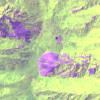

In [49]:
# Show example image from training data
PIL.Image.open(r"{}image/tiles2_tiles_landslide_4-002-010-001-002.tif".format(base_dirJ))

### Preprocess the data

In [50]:
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dirJ = "./Japan Landslide dataset/"


def check_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"Created directory: {path}")


# Training images
train_img_dir = os.path.join(base_dirJ, "image/")
train_mask_dir = os.path.join(base_dirJ, "label/")

training_images_list = os.listdir(train_img_dir)
training_images = []
training_masks = []

for n in training_images_list:
    im = Image.open(os.path.join(train_img_dir, n))
    training_images.append(im)
    filename_no_ext = os.path.splitext(n)[0]
    
    mask_name = "masks_" + filename_no_ext + ".png"
    
    if not os.path.exists(os.path.join(train_mask_dir, mask_name)):
        mask_name = n 
        
    mask = Image.open(os.path.join(train_mask_dir, mask_name))
    training_masks.append(mask)


val_img_dir = os.path.join(base_dirJ, "val/images/")
val_mask_dir = os.path.join(base_dirJ, "val/masks/")
check_dir(val_img_dir)
check_dir(val_mask_dir)

validation_images_list = os.listdir(val_img_dir)
validation_images = []
validation_masks = []

for n in validation_images_list:
    im = Image.open(os.path.join(val_img_dir, n))
    validation_images.append(im)

    filename_no_ext = os.path.splitext(n)[0]
    
    mask_name = "masks_" + filename_no_ext + ".png"
    if not os.path.exists(os.path.join(val_mask_dir, mask_name)):
        mask_name = n
    mask = Image.open(os.path.join(val_mask_dir, mask_name))
    validation_masks.append(mask)

# Test images
test_dir = os.path.join(base_dirJ, "test/image/")
check_dir(test_dir)
test_images_list = os.listdir(test_dir)
test_images = []
for n in test_images_list:
    im = Image.open(os.path.join(test_dir, n))
    test_images.append(im)

In [51]:

target_shape = (512, 512)

for i in range(len(training_images)):
    training_images[i] = training_images[i].resize(target_shape)
    training_images[i] = np.array(training_images[i]) / 255.0
    training_images[i] = training_images[i].reshape(512, 512, 3).astype('float32')

for i in range(len(training_masks)):
    training_masks[i] = training_masks[i].resize(target_shape)
    training_masks[i] = np.array(training_masks[i])

    training_masks[i][training_masks[i] > 0] = 1 
    training_masks[i][training_masks[i] <= 0] = 0
    
    training_masks[i] = training_masks[i][:512, :512]
    training_masks[i] = training_masks[i].reshape(512, 512, 1).astype('int')

for i in range(len(validation_images)):
    validation_images[i] = validation_images[i].resize(target_shape)
    validation_images[i] = np.array(validation_images[i]) / 255.0
    validation_images[i] = validation_images[i].reshape(1, 512, 512, 3).astype('float32')

for i in range(len(validation_masks)):
    validation_masks[i] = validation_masks[i].resize(target_shape)
    validation_masks[i] = np.array(validation_masks[i])
    validation_masks[i][validation_masks[i] > 0] = 1
    validation_masks[i][validation_masks[i] <= 0] = 0
    validation_masks[i] = validation_masks[i].reshape(1, 512, 512, 1).astype('int')

for i in range(len(test_images)):
    test_images[i] = test_images[i].resize(target_shape)
    test_images[i] = np.array(test_images[i]) / 255.0
    test_images[i] = test_images[i].reshape(1, 512, 512, 3).astype('float32')

In [52]:
if len(training_images) > 10: 
    split_index = len(training_images) - 5
    
    for i in range(split_index, len(training_images)):
        validation_images.append(training_images[i].reshape(1, 512, 512, 3))
        validation_masks.append(training_masks[i].reshape(1, 512, 512, 1))
    
    training_images = training_images[0:split_index]
    training_masks = training_masks[0:split_index]

if len(validation_images) > 0:
    v_images_stacked = np.vstack(validation_images)
    v_masks_stacked = np.vstack(validation_masks)
    validation_df_J = tf.data.Dataset.from_tensor_slices((v_images_stacked, v_masks_stacked))

In [53]:

def adjustData(img, mask, num_class):
    mask[mask > 0.5] = 1 # LANDSLIDE
    mask[mask <= 0.5] = 0 # NON-LANDSLIDE
    return (img, mask)

def trainGenerator(batch_size,
                   image_array,
                   mask_array,
                   aug_dict,
                   image_save_prefix  = "image",
                   mask_save_prefix  = "mask",
                   num_class = 2,
                   save_to_dir = None,
                   target_size = (512,512),
                   seed = 1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow(image_array,
                                         batch_size = batch_size,
                                         save_to_dir = save_to_dir,
                                         save_prefix = image_save_prefix,
                                         seed = seed) 

    mask_generator = mask_datagen.flow(mask_array,
                                       batch_size = batch_size,
                                       save_to_dir = save_to_dir,
                                       save_prefix = mask_save_prefix,
                                       seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img,mask) in train_generator: 
        img, mask = adjustData(img, mask, num_class)
        yield (img, mask)


In [54]:

t_imagesJ = np.stack(training_images)
t_masksJ = np.stack(training_masks)

data_gen_args = dict(rotation_range=90,        
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    shear_range=0.1,
                    zoom_range=0.1,
                    horizontal_flip=True,
                    vertical_flip = True,
                    fill_mode='reflect')

train_gen = trainGenerator(batch_size=2,
                           image_array=t_imagesJ, 
                           mask_array=t_masksJ, 
                           aug_dict=data_gen_args, 
                           save_to_dir=None)


### New Evaluation Method: IoU

In [55]:

def iou_score(y_true, y_pred):
    # smooth 用于防止分母为 0
    smooth = 1e-6
    
    # 展平数据 (从 [Batch, 512, 512, 1] 变成一维向量)
    # 这样方便计算所有像素的点积
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    # 计算交集 (Intersection): 只有两个都为 1 时，乘积才为 1
    intersection = K.sum(y_true_f * y_pred_f)
    
    # 计算并集 (Union): A + B - 交集
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    
    # 计算 IoU
    return (intersection + smooth) / (union + smooth)

### New Model

In [ ]:

tf.keras.backend.clear_session()

try:
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print("Mixed precision enabled.")
except Exception as e:
    print(f"Mixed precision not enabled: {e}")
    pass

'''
  Convolutional block with set parameters and activation layer after
'''
def convBlock(x, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
    if transpose == False:
        conv = Conv2D(filters, kernel, padding='same', kernel_initializer=kernel_init)(x)
    else:
        conv = Conv2DTranspose(filters, kernel, padding='same', kernel_initializer=kernel_init)(x)

    conv = Activation(act)(conv)
    return conv

'''
  U-Net model
'''
def UNet(trained_weights=None, input_size=(512, 512, 3), drop_rate=0.25, lr=0.0001):

    # Input layer
    inputs = Input(input_size)

    ## Contraction phase (Encoder)
    conv1 = convBlock(inputs, 64, 3)
    conv1 = convBlock(conv1, 64, 3)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = convBlock(pool1, 128, 3)
    conv2 = convBlock(conv2, 128, 3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    # drop2 = Dropout(drop_rate)(pool2)

    conv3 = convBlock(pool2, 256, 3)
    conv3 = convBlock(conv3, 256, 3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # drop3 = Dropout(drop_rate)(pool3)

    conv4 = convBlock(pool3, 512, 3)
    conv4 = convBlock(conv4, 512, 3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    # drop4 = Dropout(drop_rate)(pool4)

    # Bottleneck
    conv5 = convBlock(pool4, 1024, 3)
    conv5 = convBlock(conv5, 1024, 3)

    ## Expansion phase (Decoder)
    up6 = Conv2DTranspose(512, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5)
    merge6 = concatenate([conv4, up6])
    conv6 = convBlock(merge6, 512, 3)
    conv6 = convBlock(conv6, 512, 3)

    up7 = Conv2DTranspose(256, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6)
    merge7 = concatenate([conv3, up7])
    conv7 = convBlock(merge7, 256, 3)
    conv7 = convBlock(conv7, 256, 3)

    up8 = Conv2DTranspose(128, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv7)
    merge8 = concatenate([conv2, up8])
    conv8 = convBlock(merge8, 128, 3)
    conv8 = convBlock(conv8, 128, 3)

    up9 = Conv2DTranspose(64, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv8)
    merge9 = concatenate([conv1, up9])
    conv9 = convBlock(merge9, 64, 3)
    conv9 = convBlock(conv9, 64, 3)

    # Output layer
    conv10 = Conv2D(1, 1, padding='same', kernel_initializer='he_normal')(conv9)
    outputs = Activation('sigmoid', dtype='float32', name='predictions')(conv10)

    model = Model(inputs, outputs)

    # Compile
    model.compile(optimizer=Adam(learning_rate=lr), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy', 'mse', iou_score])

    if trained_weights is not None:
        model.load_weights(trained_weights)

    return model

Mixed precision enabled.


In [ ]:

tf.keras.backend.clear_session()
try:
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print("Mixed precision enabled (float16 compute, float32 variables).")
except Exception as e:
    print(f"Mixed precision setup failed: {e}")

def convBlock(x, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
    if transpose == False:
        conv = Conv2D(filters, kernel, padding='same', kernel_initializer=kernel_init)(x)
    else:
        conv = Conv2DTranspose(filters, kernel, padding='same', kernel_initializer=kernel_init)(x)
    conv = Activation(act)(conv)
    return conv

def convBlock2(x, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
    if transpose == False:
        conv = Conv2D(filters, kernel, padding='same', kernel_initializer=kernel_init)(x)
        conv = Activation(act)(conv)
        conv = Conv2D(filters, kernel, padding='same', kernel_initializer=kernel_init)(conv)
        conv = Activation(act)(conv)
    else:
        conv = Conv2DTranspose(filters, kernel, padding='same', kernel_initializer=kernel_init)(x)
        conv = Activation(act)(conv)
        conv = Conv2DTranspose(filters, kernel, padding='same', kernel_initializer=kernel_init)(conv)
        conv = Activation(act)(conv)
    return conv

def attention_block(x, gating, inter_shape, drop_rate=0.25):
    
    
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    phi_g = Conv2D(inter_shape, (1, 1), padding='same', kernel_initializer='he_normal')(gating)
    
    theta_x = Conv2D(inter_shape, (1, 1), padding='same', kernel_initializer='he_normal')(x)
    
    theta_x = MaxPooling2D(pool_size=(2, 2))(theta_x)
    
    concat_xg = add([phi_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    psi = Conv2D(1, (1, 1), padding='same', kernel_initializer='he_normal')(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    
    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_g[1], shape_x[2] // shape_g[2]))(sigmoid_xg)
    
    y = multiply([upsample_psi, x])
    
    return y

def UNetAM(trained_weights=None, input_size=(512, 512, 3), drop_rate=0.25, lr=0.0001, filter_base=16):
    
    # Input layer
    inputs = Input(input_size)

    ## --- Encoder (Contraction) ---
    conv = convBlock2(inputs, filter_base, 3)
    conv0 = MaxPooling2D(pool_size=(2, 2))(conv)
    
    conv0 = convBlock2(conv0, 2 * filter_base, 3)
    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)
    
    conv1 = convBlock2(pool0, 4 * filter_base, 3)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = convBlock2(pool1, 8 * filter_base, 3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Bottleneck
    conv3 = convBlock2(pool2, 16 * filter_base, 3)

    ## --- Decoder (Expansion) with Attention ---
    
    # Block 4
    up4 = Conv2DTranspose(8 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv3)
    merge4 = attention_block(conv2, conv3, 8 * filter_base, drop_rate) 
    conv4 = concatenate([up4, merge4])
    conv4 = convBlock2(conv4, 8 * filter_base, 3)

    # Block 5
    up5 = Conv2DTranspose(4 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv4)
    merge5 = attention_block(conv1, conv4, 4 * filter_base, drop_rate) 
    conv5 = concatenate([up5, merge5])
    conv5 = convBlock2(conv5, 4 * filter_base, 3)

    # Block 6
    up6 = Conv2DTranspose(2 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5)
    merge6 = attention_block(conv0, conv5, 2 * filter_base, drop_rate) 
    conv6 = concatenate([up6, merge6])
    conv6 = convBlock2(conv6, 2 * filter_base, 3)

    # Block 7
    up7 = Conv2DTranspose(1 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6)
    merge7 = attention_block(conv, conv6, 1 * filter_base, drop_rate)
    conv7 = concatenate([up7, merge7])
    conv7 = convBlock2(conv7, 1 * filter_base, 3)

    ## --- Output Layer ---
    conv_final = Conv2D(1, 1, padding='same', kernel_initializer='he_normal')(conv7)
    
    out = Activation('sigmoid', dtype='float32', name='output_sigmoid')(conv_final)

    model = Model(inputs, out)

    model.compile(optimizer=Adam(learning_rate=lr), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy', 'mse', iou_score])

    if trained_weights is not None:
        model.load_weights(trained_weights)

    return model

Mixed precision enabled (float16 compute, float32 variables).


In [ ]:

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print("Mixed precision policy set to:", policy.name)

class MaxPoolingWithArgmax2D(Layer):
    def __init__(self, pool_size=(2, 2), strides=(2, 2), padding="same", **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        
        ksize = [1, pool_size[0], pool_size[1], 1]
        padding = padding.upper()
        strides = [1, strides[0], strides[1], 1]
        
        output, argmax = tf.nn.max_pool_with_argmax(
            inputs, ksize=ksize, strides=strides, padding=padding
        )
        
        argmax = K.cast(argmax, 'float32') 
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        ratio = (1, 2, 2, 1)
        output_shape = [
            dim // ratio[i] if dim is not None else None
            for i, dim in enumerate(input_shape)
        ]
        return output_shape, output_shape

class MaxUnpooling2D(Layer):
    def __init__(self, size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.size = size

    def call(self, inputs, output_shape=None):
        updates, mask = inputs[0], inputs[1]
        
        mask = K.cast(mask, "int32")
        input_shape = tf.shape(updates, out_type="int32")
        
        if output_shape is None:
            output_shape = (
                input_shape[0],
                input_shape[1] * self.size[0],
                input_shape[2] * self.size[1],
                input_shape[3],
            )
        self.output_shape1 = output_shape

        one_like_mask = K.ones_like(mask, dtype="int32")
        batch_shape = K.concatenate([[input_shape[0]], [1], [1], [1]], axis=0)
        batch_range = K.reshape(
            tf.range(output_shape[0], dtype="int32"), shape=batch_shape
        )
        b = one_like_mask * batch_range
        y = mask // (output_shape[2] * output_shape[3])
        x = (mask // output_shape[3]) % output_shape[2]
        feature_range = tf.range(output_shape[3], dtype="int32")
        f = one_like_mask * feature_range

        updates_size = tf.size(updates)
        indices = K.transpose(K.reshape(K.stack([b, y, x, f]), [4, updates_size]))
        values = K.reshape(updates, [updates_size])
        ret = tf.scatter_nd(indices, values, output_shape)
        return ret

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
            mask_shape[0],
            mask_shape[1] * self.size[0],
            mask_shape[2] * self.size[1],
            mask_shape[3],
        )

def resnetConvDownBlock(x, filter, kernel, act='relu'):
    for i in range(2): 
        x = ZeroPadding2D((1,1))(x) 
        x = Conv2D(filters = filter, kernel_size = kernel, kernel_initializer = 'he_normal')(x)
        x = Activation('relu')(x)
    return x

def resnetConvUpBlock(x, skip_connection = None, filter = None, kernel = None, act='relu'):
    out = x
    out = UpSampling2D((2,2))(out)

    for i in range(2):
        out = ZeroPadding2D((1,1))(out)
        out = Conv2D(filters = filter, kernel_size = kernel, kernel_initializer = 'he_normal')(out)
        out = Activation('relu')(out)

    if skip_connection != None:
        out = Add()([out, skip_connection])

    return out


def ResNet50SegNet(input_size=(512,512,3), lr = 0.0001, filters = 16, kernel_sz = 3):
    
    inputs = Input(input_size)

    # --- Encoder ---
    block1 = resnetConvDownBlock(inputs, filter = filters, kernel = kernel_sz)
    pool1, mask1 = MaxPoolingWithArgmax2D((2,2))(block1)
    
    block2 = resnetConvDownBlock(pool1, filter = 2 * filters, kernel = kernel_sz)
    pool2, mask2 = MaxPoolingWithArgmax2D((2,2))(block2)
    
    block3 = resnetConvDownBlock(pool2, filter = 4 * filters, kernel = kernel_sz)
    pool3, mask3 = MaxPoolingWithArgmax2D((2,2))(block3)
    
    block4 = resnetConvDownBlock(pool3, filter = 8 * filters, kernel = kernel_sz)
    pool4, mask4 = MaxPoolingWithArgmax2D((2,2))(block4)
    
    block5 = resnetConvDownBlock(pool4, filter = 16 * filters, kernel = kernel_sz)
    pool5, mask5 = MaxPoolingWithArgmax2D((2,2))(block5)

    # --- Decoder ---
    block5_ = resnetConvUpBlock(pool5, filter = 16 * filters, kernel = kernel_sz)
    
    skip4 = MaxUnpooling2D((2,2))([pool4, mask4])
    block4_ = resnetConvUpBlock(block5_, skip_connection = skip4, filter = 8 * filters, kernel = kernel_sz)
    
    skip3 = MaxUnpooling2D((2,2))([pool3, mask3])
    block3_ = resnetConvUpBlock(block4_, skip_connection = skip3, filter = 4 * filters, kernel = kernel_sz)
    
    skip2 = MaxUnpooling2D((2,2))([pool2, mask2])
    block2_ = resnetConvUpBlock(block3_, skip_connection = skip2, filter = 2 * filters, kernel = kernel_sz)
    
    skip1 = MaxUnpooling2D((2,2))([pool1, mask1])
    block1_ = resnetConvUpBlock(block2_, skip_connection = skip1, filter = filters, kernel = kernel_sz)
    
    # Output
    outputs = Conv2D(1, kernel_size = 1, strides = 1, kernel_initializer = 'he_normal', dtype='float32')(block1_)
    outputs = Activation('sigmoid', dtype='float32')(outputs)

    model = Model(inputs, outputs)
    
    model.compile(optimizer = Adam(learning_rate = lr), 
                  loss = 'binary_crossentropy', 
                  metrics = ['accuracy', 'mse', iou_score])

    return model

Mixed precision policy set to: mixed_float16


In [ ]:

tf.keras.backend.clear_session()
mixed_precision.set_global_policy('mixed_float16')

def vgg_block(x, filters, num_convs=2, block_name='block'):
    for i in range(num_convs):
        name = f'{block_name}_conv{i+1}'
        x = Conv2D(filters, (3, 3), padding='same', name=name)(x)
        x = BatchNormalization()(x) 
        x = Activation('relu')(x)
    
    name_pool = f'{block_name}_pool'
    x = MaxPooling2D((2, 2), strides=(2, 2), name=name_pool)(x)
    return x

def fcn_32(input_size=(512,512,3), lr=0.0001, drop_rate=0.3):
    
    base_filters = 32 
    
    inputs = Input(shape=input_size)
    x = inputs

    # --- Encoder ---
    # Block 1: 32
    x = vgg_block(x, base_filters, num_convs=2, block_name='block1')
    # Block 2: 64
    x = vgg_block(x, base_filters * 2, num_convs=2, block_name='block2')
    # Block 3: 128
    x = vgg_block(x, base_filters * 4, num_convs=2, block_name='block3')
    # Block 4: 256
    x = vgg_block(x, base_filters * 8, num_convs=2, block_name='block4')
    # Block 5: 256
    x = vgg_block(x, base_filters * 8, num_convs=2, block_name='block5')

    # --- "Dense" Layers (Converted to Conv) ---
    # "fc6" -> conv6 (7x7)
    x = Conv2D(2048, (7, 7), padding='same', name="conv6")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(drop_rate)(x)
    
    # "fc7" -> conv7 (1x1)
    x = Conv2D(2048, (1, 1), padding='same', name="conv7")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(drop_rate)(x)

    # --- Decoder ---
    
    # Score layer
    score = Conv2D(1, (1, 1), padding='same', kernel_initializer='he_normal', name="score_fr")(x)
    
    # Upsample (32x)
    outputs = Conv2DTranspose(1, kernel_size=(64,64), strides=(32,32), 
                              padding='same', use_bias=False, name="upsample_32")(score)
    
    # Output
    outputs = Activation('sigmoid', dtype='float32')(outputs)

    model = Model(inputs, outputs, name="fcn_32_custom_512")
    
    model.compile(optimizer = Adam(learning_rate = lr), 
                  loss = 'binary_crossentropy', 
                  metrics = ['accuracy', 'mse', iou_score])
    
    return model

In [ ]:

tf.keras.backend.clear_session()
try:
    mixed_precision.set_global_policy('mixed_float16')
except:
    pass

def res_block_separable(x, num_filters, kernel_size, name):

    if isinstance(num_filters, int):
        num_filters = [num_filters, num_filters]
    elif len(num_filters) == 1:
        num_filters = [num_filters[0], num_filters[0]]

    x1 = SeparableConv2D(filters=num_filters[0], kernel_size=kernel_size, strides=1, 
                         padding='same', depth_multiplier=1, kernel_initializer='he_normal', name=name+'_sep1')(x)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    
    x1 = SeparableConv2D(filters=num_filters[1], kernel_size=kernel_size, strides=1, 
                         padding='same', depth_multiplier=1, kernel_initializer='he_normal', name=name+'_sep2')(x1)
    x1 = BatchNormalization()(x1)

    if x.shape[-1] != num_filters[-1]:
        shortcut = Conv2D(filters=num_filters[-1], kernel_size=1, strides=1, 
                          padding='same', kernel_initializer='he_normal', name=name+'_shortcut')(x)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = x

    x1 = Add()([shortcut, x1])
    x1 = Activation('relu')(x1)
    return x1

def upsample(x, target_size):
    return Lambda(lambda x: tf.image.resize(x, target_size, method='nearest'))(x)


def encoder(x, num_filters, kernel_size):
    encoder_output = []
    
    x = res_block_separable(x, [num_filters[0]], kernel_size, name='enc_L1')
    encoder_output.append(x)
    
    for i in range(1, len(num_filters)):
        x = MaxPooling2D(pool_size=(2, 2), name=f'enc_pool_{i}')(x)
        x = res_block_separable(x, [num_filters[i]], kernel_size, name=f'enc_L{i+1}')
        encoder_output.append(x)
        
    return encoder_output

def decoder(x, encoder_output, num_filters, kernel_size):
    for i in range(1, len(num_filters) + 1):
        target_shape = tf.keras.backend.int_shape(encoder_output[-i])[1:3]
        
        x = upsample(x, target_shape)
        x = Concatenate(axis=-1)([x, encoder_output[-i]])
        
        x = res_block_separable(x, [num_filters[-i]], kernel_size, name=f'dec_L{i}')
    return x

def res_unet(input_size=512, 
                  num_filters=[16, 32, 64, 128], 
                  kernel_size=3, 
                  num_channels=3, 
                  num_classes=1, 
                  lr=0.0001):
    
    inputs = Input(shape=[input_size, input_size, num_channels])

    enc_out = encoder(inputs, num_filters, kernel_size)

    x = MaxPooling2D(pool_size=(2, 2), name='bridge_pool')(enc_out[-1])
    bridge = res_block_separable(x, [num_filters[-1]*2], kernel_size, name='bridge')

    dec_out = decoder(bridge, enc_out, num_filters, kernel_size)

    output = Conv2D(num_classes, 1, strides=1, padding='same', name='output')(dec_out)
    output = Activation('sigmoid', dtype='float32')(output)

    model = Model(inputs, output, name=f'ResUnet_Lite_F{num_filters[0]}')
    
    model.compile(optimizer=Adam(learning_rate=lr), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy', iou_score])

    return model


### Train on Japan Dataset

#### U-net

In [ ]:
# Train U-Net with generator
J_unet = UNet(input_size=(512,512,3), lr=0.0001)
BATCH_SIZE = 2 

validation_data_batched = validation_df_J.batch(BATCH_SIZE)

save_J = ModelCheckpoint('unet-J.hdf5', monitor='val_iou_score', mode='max', verbose=1, save_best_only=True)
train = trainGenerator(1, t_imagesJ, t_masksJ, data_gen_args, save_to_dir=None)

J_unet.fit(train, steps_per_epoch=100, epochs=30, validation_data = validation_data_batched, callbacks=[save_J])

Epoch 1/30
100/100 [==============================] - ETA: 0s - loss: 0.0959 - accuracy: 0.9884 - mse: 0.0168 - iou_score: 0.0070
Epoch 1: val_iou_score improved from -inf to 0.01286, saving model to unet-J.hdf5
100/100 [==============================] - 66s 646ms/step - loss: 0.0959 - accuracy: 0.9884 - mse: 0.0168 - iou_score: 0.0070 - val_loss: 0.0526 - val_accuracy: 0.9932 - val_mse: 0.0087 - val_iou_score: 0.0129
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 0.0569 - accuracy: 0.9914 - mse: 0.0097 - iou_score: 0.0083
Epoch 2: val_iou_score improved from 0.01286 to 0.01416, saving model to unet-J.hdf5
100/100 [==============================] - 9s 95ms/step - loss: 0.0569 - accuracy: 0.9914 - mse: 0.0097 - iou_score: 0.0083 - val_loss: 0.0358 - val_accuracy: 0.9932 - val_mse: 0.0071 - val_iou_score: 0.0142
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 0.0610 - accuracy: 0.9890 - mse: 0.0134 - iou_score: 0.0232
Epoch 3: val_iou_score im

In [48]:
# Save model training history
np.save('unet-J-history.npy',J_unet.history.history)

#### Attention U-net

In [47]:
# Train Attention U-Net with generator
J_attention_unet = UNetAM(lr=0.0005, filter_base=16)
save_J_am = ModelCheckpoint('unet-attention-J.hdf5', monitor='val_iou_score', mode='max',verbose=1, save_best_only=True)
train = trainGenerator(1, t_imagesJ, t_masksJ, data_gen_args, save_to_dir=None)
J_attention_unet.fit(train, steps_per_epoch=100, epochs=50, validation_data = validation_data_batched, callbacks=[save_J_am])

Epoch 1/50
 99/100 [============================>.] - ETA: 0s - loss: 0.1281 - accuracy: 0.9677 - mse: 0.0298 - iou_score: 0.0069
Epoch 1: val_iou_score improved from -inf to 0.01582, saving model to unet-attention-J.hdf5
100/100 [==============================] - 6s 41ms/step - loss: 0.1274 - accuracy: 0.9681 - mse: 0.0296 - iou_score: 0.0068 - val_loss: 0.0471 - val_accuracy: 0.9932 - val_mse: 0.0078 - val_iou_score: 0.0158
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.0534 - accuracy: 0.9914 - mse: 0.0093 - iou_score: 0.0095
Epoch 2: val_iou_score improved from 0.01582 to 0.01584, saving model to unet-attention-J.hdf5
100/100 [==============================] - 4s 38ms/step - loss: 0.0534 - accuracy: 0.9914 - mse: 0.0093 - iou_score: 0.0095 - val_loss: 0.0355 - val_accuracy: 0.9932 - val_mse: 0.0067 - val_iou_score: 0.0158
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.0572 - accuracy: 0.9890 - mse: 0.0114 - iou_score: 0.0182
Epoch 3

In [49]:
# Save model history
np.save('unet-attention-J-history.npy', J_attention_unet.history.history)

#### ResNet50-SegNet

In [50]:
RJ = ResNet50SegNet()
save_J_resnet = ModelCheckpoint('resnet50segnet-J.hdf5', monitor='val_iou_score', mode='max',verbose=1, save_best_only=True, save_weights_only=True)
train = trainGenerator(1, t_imagesJ, t_masksJ, data_gen_args, save_to_dir=None)
RJ.fit(train, validation_data = validation_data_batched, epochs = 40, steps_per_epoch = 100, callbacks=[save_J_resnet])

Epoch 1/40
 99/100 [============================>.] - ETA: 0s - loss: 0.1776 - accuracy: 0.9411 - mse: 0.0423 - iou_score: 0.0046
Epoch 1: val_iou_score improved from -inf to 0.00571, saving model to resnet50segnet-J.hdf5
100/100 [==============================] - 7s 49ms/step - loss: 0.1762 - accuracy: 0.9416 - mse: 0.0419 - iou_score: 0.0046 - val_loss: 0.1146 - val_accuracy: 0.9911 - val_mse: 0.0164 - val_iou_score: 0.0057
Epoch 2/40
 99/100 [============================>.] - ETA: 0s - loss: 0.0662 - accuracy: 0.9905 - mse: 0.0100 - iou_score: 0.0030
Epoch 2: val_iou_score did not improve from 0.00571
100/100 [==============================] - 4s 44ms/step - loss: 0.0656 - accuracy: 0.9906 - mse: 0.0099 - iou_score: 0.0029 - val_loss: 0.0548 - val_accuracy: 0.9931 - val_mse: 0.0068 - val_iou_score: 7.8040e-04
Epoch 3/40
100/100 [==============================] - ETA: 0s - loss: 0.0766 - accuracy: 0.9889 - mse: 0.0134 - iou_score: 0.0038
Epoch 3: val_iou_score did not improve from 0.

In [51]:
# Save model history
np.save('resnet50segnet-J-history.npy', RJ.history.history)

#### FCN VGG16

In [52]:
FJ = fcn_32(lr = 0.0001)
save_J_fcn32 = ModelCheckpoint('fcn32-J.hdf5', monitor='val_iou_score', mode='max', verbose=1, save_best_only=True)
train = trainGenerator(1, t_imagesJ, t_masksJ, data_gen_args, save_to_dir=None)
FJ.fit(train, validation_data = validation_data_batched, epochs=50, steps_per_epoch = 100, shuffle = True, callbacks=[save_J_fcn32])

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.5906 - accuracy: 0.7231 - mse: 0.2014 - iou_score: 0.0108
Epoch 1: val_iou_score improved from -inf to 0.00636, saving model to fcn32-J.hdf5
100/100 [==============================] - 6s 48ms/step - loss: 0.5906 - accuracy: 0.7231 - mse: 0.2014 - iou_score: 0.0108 - val_loss: 0.5521 - val_accuracy: 0.9439 - val_mse: 0.1809 - val_iou_score: 0.0064
Epoch 2/50
 99/100 [============================>.] - ETA: 0s - loss: 0.2431 - accuracy: 0.9794 - mse: 0.0573 - iou_score: 0.0082
Epoch 2: val_iou_score did not improve from 0.00636
100/100 [==============================] - 4s 40ms/step - loss: 0.2418 - accuracy: 0.9796 - mse: 0.0569 - iou_score: 0.0081 - val_loss: 0.1993 - val_accuracy: 0.9929 - val_mse: 0.0431 - val_iou_score: 0.0058
Epoch 3/50
 99/100 [============================>.] - ETA: 0s - loss: 0.0996 - accuracy: 0.9901 - mse: 0.0169 - iou_score: 0.0125
Epoch 3: val_iou_score did not improve from 0.00636
100/100

In [53]:
# Save model history
np.save('fcn32-J-history.npy', FJ.history.history)

#### ResNet

In [54]:
RJ = res_unet(512, [16, 32, 64, 128], 3, 3, 1)
save_J_resunet = ModelCheckpoint('resunet-J.hdf5', monitor='val_iou_score', mode='max', verbose=1, save_best_only=True, save_weights_only=True)
train = trainGenerator(1, t_imagesJ, t_masksJ, data_gen_args, save_to_dir=None)
RJ.fit(train, validation_data = validation_data_batched, epochs = 40, steps_per_epoch = 100, callbacks=[save_J_resunet])

Epoch 1/40
 99/100 [============================>.] - ETA: 0s - loss: 0.4370 - accuracy: 0.8557 - iou_score: 0.0122
Epoch 1: val_iou_score improved from -inf to 0.00672, saving model to resunet-J.hdf5
100/100 [==============================] - 10s 54ms/step - loss: 0.4362 - accuracy: 0.8563 - iou_score: 0.0120 - val_loss: 0.6633 - val_accuracy: 0.5963 - val_iou_score: 0.0067
Epoch 2/40
 99/100 [============================>.] - ETA: 0s - loss: 0.2383 - accuracy: 0.9796 - iou_score: 0.0114
Epoch 2: val_iou_score did not improve from 0.00672
100/100 [==============================] - 5s 48ms/step - loss: 0.2382 - accuracy: 0.9797 - iou_score: 0.0113 - val_loss: 0.5723 - val_accuracy: 0.9850 - val_iou_score: 0.0067
Epoch 3/40
100/100 [==============================] - ETA: 0s - loss: 0.1759 - accuracy: 0.9862 - iou_score: 0.0149
Epoch 3: val_iou_score improved from 0.00672 to 0.00679, saving model to resunet-J.hdf5
100/100 [==============================] - 5s 49ms/step - loss: 0.1759 - a

In [55]:
# Save model history
np.save('resunet-J-history.npy', RJ.history.history)

## Improvement 1: BCE dice loss

In [ ]:

def dice_coef(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32) 
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [ ]:

tf.keras.backend.clear_session()
try:
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
except Exception as e:
    print(f"Mixed precision setup failed: {e}")

def convBlock(x, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
    if transpose == False:
        conv = Conv2D(filters, kernel, padding='same', kernel_initializer=kernel_init)(x)
    else:
        conv = Conv2DTranspose(filters, kernel, padding='same', kernel_initializer=kernel_init)(x)
    conv = Activation(act)(conv)
    return conv

def convBlock2(x, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
    if transpose == False:
        conv = Conv2D(filters, kernel, padding='same', kernel_initializer=kernel_init)(x)
        conv = Activation(act)(conv)
        conv = Conv2D(filters, kernel, padding='same', kernel_initializer=kernel_init)(conv)
        conv = Activation(act)(conv)
    else:
        conv = Conv2DTranspose(filters, kernel, padding='same', kernel_initializer=kernel_init)(x)
        conv = Activation(act)(conv)
        conv = Conv2DTranspose(filters, kernel, padding='same', kernel_initializer=kernel_init)(conv)
        conv = Activation(act)(conv)
    return conv

# --- Attention Block ---
def attention_block(x, gating, inter_shape, drop_rate=0.25):
    
    
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    phi_g = Conv2D(inter_shape, (1, 1), padding='same', kernel_initializer='he_normal')(gating)
    
    theta_x = Conv2D(inter_shape, (1, 1), padding='same', kernel_initializer='he_normal')(x)
    theta_x = MaxPooling2D(pool_size=(2, 2))(theta_x)
    
    concat_xg = add([phi_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    psi = Conv2D(1, (1, 1), padding='same', kernel_initializer='he_normal')(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    
    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_g[1], shape_x[2] // shape_g[2]))(sigmoid_xg)
    
    y = multiply([upsample_psi, x])
    
    return y

def UNetAM(trained_weights=None, input_size=(512, 512, 3), drop_rate=0.25, lr=0.0001, filter_base=16):
    
    # Input layer
    inputs = Input(input_size)

    ## --- Encoder (Contraction) ---
    conv = convBlock2(inputs, filter_base, 3)
    conv0 = MaxPooling2D(pool_size=(2, 2))(conv)
    
    conv0 = convBlock2(conv0, 2 * filter_base, 3)
    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)
    
    conv1 = convBlock2(pool0, 4 * filter_base, 3)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = convBlock2(pool1, 8 * filter_base, 3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Bottleneck
    conv3 = convBlock2(pool2, 16 * filter_base, 3)

    ## --- Decoder (Expansion) with Attention ---
    
    # Block 4
    up4 = Conv2DTranspose(8 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv3)
    merge4 = attention_block(conv2, conv3, 8 * filter_base, drop_rate) 
    conv4 = concatenate([up4, merge4])
    conv4 = convBlock2(conv4, 8 * filter_base, 3)

    # Block 5
    up5 = Conv2DTranspose(4 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv4)
    merge5 = attention_block(conv1, conv4, 4 * filter_base, drop_rate) 
    conv5 = concatenate([up5, merge5])
    conv5 = convBlock2(conv5, 4 * filter_base, 3)

    # Block 6
    up6 = Conv2DTranspose(2 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5)
    merge6 = attention_block(conv0, conv5, 2 * filter_base, drop_rate) 
    conv6 = concatenate([up6, merge6])
    conv6 = convBlock2(conv6, 2 * filter_base, 3)

    # Block 7
    up7 = Conv2DTranspose(1 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6)
    merge7 = attention_block(conv, conv6, 1 * filter_base, drop_rate)
    conv7 = concatenate([up7, merge7])
    conv7 = convBlock2(conv7, 1 * filter_base, 3)

    conv_final = Conv2D(1, 1, padding='same', kernel_initializer='he_normal')(conv7)
    
    out = Activation('sigmoid', dtype='float32', name='output_sigmoid')(conv_final)

    model = Model(inputs, out)

    model.compile(optimizer=Adam(learning_rate=lr), 
                  loss=bce_dice_loss, 
                  metrics=['accuracy', 'mse', dice_coef])

    if trained_weights is not None:
        model.load_weights(trained_weights)

    return model

Mixed precision enabled (float16 compute, float32 variables).


In [57]:

tf.keras.backend.clear_session()
try:
    mixed_precision.set_global_policy('mixed_float16')
except Exception as e:
    pass

def vgg_block(x, filters, num_convs=2, block_name='block'):
    for i in range(num_convs):
        name = f'{block_name}_conv{i+1}'
        x = Conv2D(filters, (3, 3), padding='same', name=name)(x)
        x = BatchNormalization()(x) 
        x = Activation('relu')(x)
    
    name_pool = f'{block_name}_pool'
    x = MaxPooling2D((2, 2), strides=(2, 2), name=name_pool)(x)
    return x

def fcn_32(input_size=(512,512,3), lr=0.0001, drop_rate=0.3):
    
    base_filters = 32 
    
    inputs = Input(shape=input_size)
    x = inputs

    # --- Encoder ---
    # Block 1: 32
    x = vgg_block(x, base_filters, num_convs=2, block_name='block1')
    # Block 2: 64
    x = vgg_block(x, base_filters * 2, num_convs=2, block_name='block2')
    # Block 3: 128
    x = vgg_block(x, base_filters * 4, num_convs=2, block_name='block3')
    # Block 4: 256
    x = vgg_block(x, base_filters * 8, num_convs=2, block_name='block4')
    # Block 5: 256 
    x = vgg_block(x, base_filters * 8, num_convs=2, block_name='block5')

    # --- "Dense" Layers (Converted to Conv) ---
    # "fc6" -> conv6 (7x7)
    x = Conv2D(2048, (7, 7), padding='same', name="conv6")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(drop_rate)(x)
    
    # "fc7" -> conv7 (1x1)
    x = Conv2D(2048, (1, 1), padding='same', name="conv7")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(drop_rate)(x)

    # --- Decoder ---
    score = Conv2D(1, (1, 1), padding='same', kernel_initializer='he_normal', name="score_fr")(x)
    
    # Upsample (32x)
    outputs = Conv2DTranspose(1, kernel_size=(64,64), strides=(32,32), 
                              padding='same', use_bias=False, name="upsample_32")(score)
    
    # Output
    outputs = Activation('sigmoid', dtype='float32')(outputs)

    model = Model(inputs, outputs, name="fcn_32_custom_512")
    
    model.compile(optimizer = Adam(learning_rate = lr), 
                  loss=bce_dice_loss, 
                  metrics=['accuracy', 'mse', dice_coef])
    
    return model

In [ ]:

tf.keras.backend.clear_session()
try:
    mixed_precision.set_global_policy('mixed_float16')
except:
    pass

def res_block_separable(x, num_filters, kernel_size, name):
    if isinstance(num_filters, int):
        num_filters = [num_filters, num_filters]
    elif len(num_filters) == 1:
        num_filters = [num_filters[0], num_filters[0]]

    x1 = SeparableConv2D(filters=num_filters[0], kernel_size=kernel_size, strides=1, 
                         padding='same', depth_multiplier=1, kernel_initializer='he_normal', name=name+'_sep1')(x)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    
    x1 = SeparableConv2D(filters=num_filters[1], kernel_size=kernel_size, strides=1, 
                         padding='same', depth_multiplier=1, kernel_initializer='he_normal', name=name+'_sep2')(x1)
    x1 = BatchNormalization()(x1)

    if x.shape[-1] != num_filters[-1]:
        shortcut = Conv2D(filters=num_filters[-1], kernel_size=1, strides=1, 
                          padding='same', kernel_initializer='he_normal', name=name+'_shortcut')(x)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = x

    x1 = Add()([shortcut, x1])
    x1 = Activation('relu')(x1)
    return x1

def upsample(x, target_size):
    return Lambda(lambda x: tf.image.resize(x, target_size, method='nearest'))(x)


def encoder(x, num_filters, kernel_size):
    encoder_output = []
    
    x = res_block_separable(x, [num_filters[0]], kernel_size, name='enc_L1')
    encoder_output.append(x)
    
    for i in range(1, len(num_filters)):
        x = MaxPooling2D(pool_size=(2, 2), name=f'enc_pool_{i}')(x)
        x = res_block_separable(x, [num_filters[i]], kernel_size, name=f'enc_L{i+1}')
        encoder_output.append(x)
        
    return encoder_output

def decoder(x, encoder_output, num_filters, kernel_size):
    for i in range(1, len(num_filters) + 1):
        target_shape = tf.keras.backend.int_shape(encoder_output[-i])[1:3]
        
        x = upsample(x, target_shape)
        x = Concatenate(axis=-1)([x, encoder_output[-i]])
        
        x = res_block_separable(x, [num_filters[-i]], kernel_size, name=f'dec_L{i}')
    return x


def res_unet(input_size=512, 
                  num_filters=[16, 32, 64, 128], 
                  kernel_size=3, 
                  num_channels=3, 
                  num_classes=1, 
                  lr=0.0001):
    
    inputs = Input(shape=[input_size, input_size, num_channels])

    enc_out = encoder(inputs, num_filters, kernel_size)

    x = MaxPooling2D(pool_size=(2, 2), name='bridge_pool')(enc_out[-1])
    bridge = res_block_separable(x, [num_filters[-1]*2], kernel_size, name='bridge')

    dec_out = decoder(bridge, enc_out, num_filters, kernel_size)

    output = Conv2D(num_classes, 1, strides=1, padding='same', name='output')(dec_out)
    output = Activation('sigmoid', dtype='float32')(output)

    model = Model(inputs, output, name=f'ResUnet_Lite_F{num_filters[0]}')
    
    model.compile(optimizer=Adam(learning_rate=lr), 
                  loss=bce_dice_loss, 
                  metrics=['accuracy', 'mse', dice_coef])

    return model


In [66]:
# Train Attention U-Net with generator
J_attention_unet1 = UNetAM(lr=0.0005, filter_base=16)
save_J_am = ModelCheckpoint('unet-attention-J2.hdf5', monitor='val_dice_coef', mode='max',verbose=1, save_best_only=True)
train = trainGenerator(1, t_imagesJ, t_masksJ, data_gen_args, save_to_dir=None)
J_attention_unet1.fit(train, steps_per_epoch=100, epochs=50, validation_data = validation_data_batched, callbacks=[save_J_am])

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 1.1045 - accuracy: 0.9829 - mse: 0.0196 - dice_coef: 0.0119
Epoch 1: val_dice_coef improved from -inf to 0.01980, saving model to unet-attention-J2.hdf5
100/100 [==============================] - 6s 42ms/step - loss: 1.1045 - accuracy: 0.9829 - mse: 0.0196 - dice_coef: 0.0119 - val_loss: 1.0770 - val_accuracy: 0.9932 - val_mse: 0.0157 - val_dice_coef: 0.0198
Epoch 2/50
 99/100 [============================>.] - ETA: 0s - loss: 1.0427 - accuracy: 0.9913 - mse: 0.0110 - dice_coef: 0.0232
Epoch 2: val_dice_coef improved from 0.01980 to 0.04539, saving model to unet-attention-J2.hdf5
100/100 [==============================] - 4s 40ms/step - loss: 1.0438 - accuracy: 0.9914 - mse: 0.0112 - dice_coef: 0.0229 - val_loss: 0.9887 - val_accuracy: 0.9932 - val_mse: 0.0072 - val_dice_coef: 0.0454
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.9814 - accuracy: 0.9841 - mse: 0.0156 - dice_coef: 0.0898
Epoch

In [72]:
# Save model history
np.save('unet-attention-J2-history.npy', J_attention_unet1.history.history)

In [68]:
FJ2 = fcn_32(lr = 0.0001)
save_J_fcn32 = ModelCheckpoint('fcn32-J2.hdf5', monitor='val_dice_coef', mode='max', verbose=1, save_best_only=True)
train = trainGenerator(1, t_imagesJ, t_masksJ, data_gen_args, save_to_dir=None)
FJ2.fit(train, validation_data = validation_data_batched, epochs=50, steps_per_epoch = 100, shuffle = True, callbacks=[save_J_fcn32])

Epoch 1/50
 99/100 [============================>.] - ETA: 0s - loss: 1.5825 - accuracy: 0.6990 - mse: 0.2075 - dice_coef: 0.0212
Epoch 1: val_dice_coef improved from -inf to 0.01230, saving model to fcn32-J2.hdf5
100/100 [==============================] - 7s 50ms/step - loss: 1.5807 - accuracy: 0.7012 - mse: 0.2066 - dice_coef: 0.0210 - val_loss: 1.5323 - val_accuracy: 0.9246 - val_mse: 0.1779 - val_dice_coef: 0.0123
Epoch 2/50
 99/100 [============================>.] - ETA: 0s - loss: 1.2312 - accuracy: 0.9734 - mse: 0.0621 - dice_coef: 0.0231
Epoch 2: val_dice_coef did not improve from 0.01230
100/100 [==============================] - 4s 44ms/step - loss: 1.2301 - accuracy: 0.9737 - mse: 0.0617 - dice_coef: 0.0228 - val_loss: 1.2185 - val_accuracy: 0.9930 - val_mse: 0.0513 - val_dice_coef: 0.0110
Epoch 3/50
 99/100 [============================>.] - ETA: 0s - loss: 1.0398 - accuracy: 0.9831 - mse: 0.0203 - dice_coef: 0.0632
Epoch 3: val_dice_coef did not improve from 0.01230
100/10

In [73]:
# Save model history
np.save('fcn32-J2-history.npy', FJ2.history.history)

In [74]:
RJ2 = res_unet(512, [16, 32, 64, 128], 3, 3, 1)
save_J2_resunet = ModelCheckpoint('resunet-J2.hdf5', monitor='val_dice_coef', mode='max', verbose=1, save_best_only=True, save_weights_only=True)
train = trainGenerator(1, t_imagesJ, t_masksJ, data_gen_args, save_to_dir=None)
RJ2.fit(train, validation_data = validation_data_batched, epochs = 40, steps_per_epoch = 100, callbacks=[save_J2_resunet])

Epoch 1/40
 99/100 [============================>.] - ETA: 0s - loss: 1.3402 - accuracy: 0.8876 - mse: 0.1057 - dice_coef: 0.0241
Epoch 1: val_dice_coef improved from -inf to 0.01281, saving model to resunet-J2.hdf5
100/100 [==============================] - 9s 53ms/step - loss: 1.3399 - accuracy: 0.8880 - mse: 0.1055 - dice_coef: 0.0239 - val_loss: 1.6130 - val_accuracy: 0.8862 - val_mse: 0.2168 - val_dice_coef: 0.0128
Epoch 2/40
 99/100 [============================>.] - ETA: 0s - loss: 1.1334 - accuracy: 0.9763 - mse: 0.0361 - dice_coef: 0.0420
Epoch 2: val_dice_coef improved from 0.01281 to 0.01301, saving model to resunet-J2.hdf5
100/100 [==============================] - 5s 49ms/step - loss: 1.1337 - accuracy: 0.9764 - mse: 0.0360 - dice_coef: 0.0416 - val_loss: 1.3725 - val_accuracy: 0.9931 - val_mse: 0.1036 - val_dice_coef: 0.0130
Epoch 3/40
100/100 [==============================] - ETA: 0s - loss: 1.0444 - accuracy: 0.9804 - mse: 0.0226 - dice_coef: 0.0781
Epoch 3: val_dice_c

In [75]:
# Save model history
np.save('resunet-J2-history.npy', RJ2.history.history)

### Improvement 2:Data Filter

In [58]:
import random 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dirJ = "./Japan Landslide dataset/"

def check_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"Created directory: {path}")


train_img_dir = os.path.join(base_dirJ, "image/")
train_mask_dir = os.path.join(base_dirJ, "label/")

training_images_list = os.listdir(train_img_dir)
training_images = []
training_masks = []

KEEP_BACKGROUND_PROB = 0.15 

total_loaded = 0
dropped_count = 0

for n in training_images_list:
    if not n.lower().endswith(('.tif', '.tiff', '.jpg', '.png')):
        continue

    img_path = os.path.join(train_img_dir, n)
    
    filename_no_ext = os.path.splitext(n)[0]
    mask_name = "masks_" + filename_no_ext + ".png"
    
    if not os.path.exists(os.path.join(train_mask_dir, mask_name)):
        mask_name = n 
    
    mask_path = os.path.join(train_mask_dir, mask_name)

    if os.path.exists(mask_path):
        temp_mask = Image.open(mask_path)
        temp_mask_arr = np.array(temp_mask)
        
        has_landslide = np.max(temp_mask_arr) > 0
        
        should_keep = False
        
        if has_landslide:
            should_keep = True
        else:
            if random.random() < KEEP_BACKGROUND_PROB:
                should_keep = True
            else:
                dropped_count += 1
        
        if should_keep:
            im = Image.open(img_path)
            training_images.append(im)
            training_masks.append(temp_mask) 
            total_loaded += 1

val_img_dir = os.path.join(base_dirJ, "val/images/")
val_mask_dir = os.path.join(base_dirJ, "val/masks/")

check_dir(val_img_dir)
check_dir(val_mask_dir)

validation_images_list = os.listdir(val_img_dir)
validation_images = []
validation_masks = []

for n in validation_images_list:
    im = Image.open(os.path.join(val_img_dir, n))
    validation_images.append(im)

    filename_no_ext = os.path.splitext(n)[0]
    
    mask_name = "masks_" + filename_no_ext + ".png"
    if not os.path.exists(os.path.join(val_mask_dir, mask_name)):
        mask_name = n
    mask = Image.open(os.path.join(val_mask_dir, mask_name))
    validation_masks.append(mask)

# Test images
test_dir = os.path.join(base_dirJ, "test/image/")
check_dir(test_dir)
test_images_list = os.listdir(test_dir)
test_images = []
for n in test_images_list:
    im = Image.open(os.path.join(test_dir, n))
    test_images.append(im)

In [59]:

target_shape = (512, 512)

for i in range(len(training_images)):
    training_images[i] = training_images[i].resize(target_shape)
    training_images[i] = np.array(training_images[i]) / 255.0
    training_images[i] = training_images[i].reshape(512, 512, 3).astype('float32')

for i in range(len(training_masks)):
    training_masks[i] = training_masks[i].resize(target_shape)
    training_masks[i] = np.array(training_masks[i])
    
    training_masks[i][training_masks[i] > 0] = 1 
    training_masks[i][training_masks[i] <= 0] = 0
    
    training_masks[i] = training_masks[i][:512, :512]
    training_masks[i] = training_masks[i].reshape(512, 512, 1).astype('int')

for i in range(len(validation_images)):
    validation_images[i] = validation_images[i].resize(target_shape)
    validation_images[i] = np.array(validation_images[i]) / 255.0
    validation_images[i] = validation_images[i].reshape(1, 512, 512, 3).astype('float32')

for i in range(len(validation_masks)):
    validation_masks[i] = validation_masks[i].resize(target_shape)
    validation_masks[i] = np.array(validation_masks[i])
    validation_masks[i][validation_masks[i] > 0] = 1
    validation_masks[i][validation_masks[i] <= 0] = 0
    validation_masks[i] = validation_masks[i].reshape(1, 512, 512, 1).astype('int')

for i in range(len(test_images)):
    test_images[i] = test_images[i].resize(target_shape)
    test_images[i] = np.array(test_images[i]) / 255.0
    test_images[i] = test_images[i].reshape(1, 512, 512, 3).astype('float32')

In [60]:

if len(training_images) > 10: 
    split_index = len(training_images) - 5
    
    for i in range(split_index, len(training_images)):
        validation_images.append(training_images[i].reshape(1, 512, 512, 3))
        validation_masks.append(training_masks[i].reshape(1, 512, 512, 1))
    
    training_images = training_images[0:split_index]
    training_masks = training_masks[0:split_index]

if len(validation_images) > 0:
    v_images_stacked = np.vstack(validation_images)
    v_masks_stacked = np.vstack(validation_masks)
    validation_df_J = tf.data.Dataset.from_tensor_slices((v_images_stacked, v_masks_stacked))

In [61]:

def adjustData(img, mask, num_class):
    mask[mask > 0.5] = 1 # LANDSLIDE
    mask[mask <= 0.5] = 0 # NON-LANDSLIDE
    return (img, mask)

def trainGenerator(batch_size,
                   image_array,
                   mask_array,
                   aug_dict,
                   image_save_prefix  = "image",
                   mask_save_prefix  = "mask",
                   num_class = 2,
                   save_to_dir = None,
                   target_size = (512,512),
                   seed = 1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow(image_array,
                                         batch_size = batch_size,
                                         save_to_dir = save_to_dir,
                                         save_prefix = image_save_prefix,
                                         seed = seed) 

    mask_generator = mask_datagen.flow(mask_array,
                                       batch_size = batch_size,
                                       save_to_dir = save_to_dir,
                                       save_prefix = mask_save_prefix,
                                       seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img,mask) in train_generator: 
        img, mask = adjustData(img, mask, num_class)
        yield (img, mask)


In [62]:

t_imagesJ = np.stack(training_images)
t_masksJ = np.stack(training_masks)

data_gen_args = dict(rotation_range=90,        
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    shear_range=0.1,
                    zoom_range=0.1,
                    horizontal_flip=True,
                    vertical_flip = True,
                    fill_mode='reflect')

train_gen = trainGenerator(batch_size=2, 
                           image_array=t_imagesJ, 
                           mask_array=t_masksJ, 
                           aug_dict=data_gen_args, 
                           save_to_dir=None)


In [86]:
# Train Attention U-Net with generator
J2_attention_unet = UNetAM(lr=0.0005, filter_base=16)
save_J2_am = ModelCheckpoint('unet-attention-J3.hdf5', monitor='val_dice_coef', mode='max',verbose=1, save_best_only=True)
train = trainGenerator(1, t_imagesJ, t_masksJ, data_gen_args, save_to_dir=None)
J2_attention_unet.fit(train, steps_per_epoch=100, epochs=50, validation_data = validation_data_batched, callbacks=[save_J2_am])

Epoch 1/50
 99/100 [============================>.] - ETA: 0s - loss: 1.0754 - accuracy: 0.9857 - mse: 0.0194 - dice_coef: 0.0229
Epoch 1: val_dice_coef improved from -inf to 0.02372, saving model to unet-attention-J3.hdf5
100/100 [==============================] - 6s 43ms/step - loss: 1.0747 - accuracy: 0.9858 - mse: 0.0192 - dice_coef: 0.0229 - val_loss: 1.0161 - val_accuracy: 0.9932 - val_mse: 0.0074 - val_dice_coef: 0.0237
Epoch 2/50
 99/100 [============================>.] - ETA: 0s - loss: 0.9691 - accuracy: 0.9770 - mse: 0.0176 - dice_coef: 0.1063
Epoch 2: val_dice_coef improved from 0.02372 to 0.02946, saving model to unet-attention-J3.hdf5
100/100 [==============================] - 4s 40ms/step - loss: 0.9695 - accuracy: 0.9772 - mse: 0.0174 - dice_coef: 0.1055 - val_loss: 1.0073 - val_accuracy: 0.9932 - val_mse: 0.0065 - val_dice_coef: 0.0295
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.9477 - accuracy: 0.9688 - mse: 0.0197 - dice_coef: 0.1360
Epoch

In [87]:
# Save model history
np.save('unet-attention-J3-history.npy', J2_attention_unet.history.history)

### Improvement 3: weighted_bce_loss

In [ ]:

def weighted_bce_loss(y_true, y_pred):
    pos_weight = 10.0 
    
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)

    loss = - (pos_weight * y_true * K.log(y_pred) + (1 - y_true) * K.log(1 - y_pred))
    
    return K.mean(loss)

def dice_coef(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


In [ ]:

tf.keras.backend.clear_session()
try:
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print("Mixed precision enabled (float16 compute, float32 variables).")
except Exception as e:
    print(f"Mixed precision setup failed: {e}")

def convBlock(x, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
    if transpose == False:
        conv = Conv2D(filters, kernel, padding='same', kernel_initializer=kernel_init)(x)
    else:
        conv = Conv2DTranspose(filters, kernel, padding='same', kernel_initializer=kernel_init)(x)
    conv = Activation(act)(conv)
    return conv

def convBlock2(x, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
    if transpose == False:
        conv = Conv2D(filters, kernel, padding='same', kernel_initializer=kernel_init)(x)
        conv = Activation(act)(conv)
        conv = Conv2D(filters, kernel, padding='same', kernel_initializer=kernel_init)(conv)
        conv = Activation(act)(conv)
    else:
        conv = Conv2DTranspose(filters, kernel, padding='same', kernel_initializer=kernel_init)(x)
        conv = Activation(act)(conv)
        conv = Conv2DTranspose(filters, kernel, padding='same', kernel_initializer=kernel_init)(conv)
        conv = Activation(act)(conv)
    return conv

# --- Attention Block ---
def attention_block(x, gating, inter_shape, drop_rate=0.25):
    
    
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    phi_g = Conv2D(inter_shape, (1, 1), padding='same', kernel_initializer='he_normal')(gating)
    
    theta_x = Conv2D(inter_shape, (1, 1), padding='same', kernel_initializer='he_normal')(x)
    theta_x = MaxPooling2D(pool_size=(2, 2))(theta_x)
    
    concat_xg = add([phi_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    psi = Conv2D(1, (1, 1), padding='same', kernel_initializer='he_normal')(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    
    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_g[1], shape_x[2] // shape_g[2]))(sigmoid_xg)
    
    y = multiply([upsample_psi, x])
    
    return y


def UNetAM(trained_weights=None, input_size=(512, 512, 3), drop_rate=0.25, lr=0.0001, filter_base=16):
    
    # Input layer
    inputs = Input(input_size)

    ## --- Encoder (Contraction) ---
    conv = convBlock2(inputs, filter_base, 3)
    conv0 = MaxPooling2D(pool_size=(2, 2))(conv)
    
    conv0 = convBlock2(conv0, 2 * filter_base, 3)
    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)
    
    conv1 = convBlock2(pool0, 4 * filter_base, 3)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = convBlock2(pool1, 8 * filter_base, 3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Bottleneck
    conv3 = convBlock2(pool2, 16 * filter_base, 3)

    ## --- Decoder (Expansion) with Attention ---
    
    # Block 4
    up4 = Conv2DTranspose(8 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv3)
    merge4 = attention_block(conv2, conv3, 8 * filter_base, drop_rate) 
    conv4 = concatenate([up4, merge4])
    conv4 = convBlock2(conv4, 8 * filter_base, 3)

    # Block 5
    up5 = Conv2DTranspose(4 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv4)
    merge5 = attention_block(conv1, conv4, 4 * filter_base, drop_rate) 
    conv5 = concatenate([up5, merge5])
    conv5 = convBlock2(conv5, 4 * filter_base, 3)

    # Block 6
    up6 = Conv2DTranspose(2 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5)
    merge6 = attention_block(conv0, conv5, 2 * filter_base, drop_rate) 
    conv6 = concatenate([up6, merge6])
    conv6 = convBlock2(conv6, 2 * filter_base, 3)

    # Block 7
    up7 = Conv2DTranspose(1 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6)
    merge7 = attention_block(conv, conv6, 1 * filter_base, drop_rate)
    conv7 = concatenate([up7, merge7])
    conv7 = convBlock2(conv7, 1 * filter_base, 3)

    ## --- Output Layer ---
    conv_final = Conv2D(1, 1, padding='same', kernel_initializer='he_normal')(conv7)
    
    out = Activation('sigmoid', dtype='float32', name='output_sigmoid')(conv_final)

    model = Model(inputs, out)

    model.compile(optimizer=Adam(learning_rate=lr), 
                  loss=weighted_bce_loss, 
                  metrics=['accuracy', 'mse', dice_coef])

    if trained_weights is not None:
        model.load_weights(trained_weights)

    return model

Mixed precision enabled (float16 compute, float32 variables).


In [96]:
# Train Attention U-Net with generator
J3_attention_unet = UNetAM(lr=0.0005, filter_base=16)
save_J3_am = ModelCheckpoint('unet-attention-J4.hdf5', monitor='val_dice_coef', mode='max',verbose=1, save_best_only=True)
train = trainGenerator(1, t_imagesJ, t_masksJ, data_gen_args, save_to_dir=None)
J3_attention_unet.fit(train, steps_per_epoch=100, epochs=50, validation_data = validation_data_batched, callbacks=[save_J3_am])

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.3743 - accuracy: 0.9873 - mse: 0.0436 - dice_coef: 0.0363
Epoch 1: val_dice_coef improved from -inf to 0.07052, saving model to unet-attention-J4.hdf5
100/100 [==============================] - 8s 48ms/step - loss: 0.3743 - accuracy: 0.9873 - mse: 0.0436 - dice_coef: 0.0363 - val_loss: 0.2016 - val_accuracy: 0.9932 - val_mse: 0.0077 - val_dice_coef: 0.0705
Epoch 2/50
 99/100 [============================>.] - ETA: 0s - loss: 0.2644 - accuracy: 0.9812 - mse: 0.0283 - dice_coef: 0.0938
Epoch 2: val_dice_coef improved from 0.07052 to 0.12685, saving model to unet-attention-J4.hdf5
100/100 [==============================] - 4s 41ms/step - loss: 0.2627 - accuracy: 0.9813 - mse: 0.0281 - dice_coef: 0.0935 - val_loss: 0.1388 - val_accuracy: 0.9933 - val_mse: 0.0087 - val_dice_coef: 0.1268
Epoch 3/50
 99/100 [============================>.] - ETA: 0s - loss: 0.2133 - accuracy: 0.9680 - mse: 0.0254 - dice_coef: 0.1543
Epoch

In [97]:
# Save model history
np.save('unet-attention-J4-history.npy', J3_attention_unet.history.history)

### Improvement 4: Data Augmentation

In [63]:

data_gen_args = dict(
    rotation_range=180,      
    width_shift_range=0.2,   
    height_shift_range=0.2,  
    zoom_range=[0.8, 1.2],   
    shear_range=0.2,         
    horizontal_flip=True,    
    vertical_flip=True,      
    fill_mode='reflect'      
)

train_gen = trainGenerator(batch_size=2,
                           image_array=t_imagesJ, 
                           mask_array=t_masksJ, 
                           aug_dict=data_gen_args, 
                           save_to_dir=None)


In [ ]:
from tensorflow.keras.metrics import Precision, Recall # <--- 引入

tf.keras.backend.clear_session()
try:
    # 启用混合精度
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print("Mixed precision enabled (float16 compute, float32 variables).")
except Exception as e:
    print(f"Mixed precision setup failed: {e}")

def convBlock(x, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
    if transpose == False:
        conv = Conv2D(filters, kernel, padding='same', kernel_initializer=kernel_init)(x)
    else:
        conv = Conv2DTranspose(filters, kernel, padding='same', kernel_initializer=kernel_init)(x)
    conv = Activation(act)(conv)
    return conv

def convBlock2(x, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
    if transpose == False:
        conv = Conv2D(filters, kernel, padding='same', kernel_initializer=kernel_init)(x)
        conv = Activation(act)(conv)
        conv = Conv2D(filters, kernel, padding='same', kernel_initializer=kernel_init)(conv)
        conv = Activation(act)(conv)
    else:
        conv = Conv2DTranspose(filters, kernel, padding='same', kernel_initializer=kernel_init)(x)
        conv = Activation(act)(conv)
        conv = Conv2DTranspose(filters, kernel, padding='same', kernel_initializer=kernel_init)(conv)
        conv = Activation(act)(conv)
    return conv

# --- Attention Block ---
def attention_block(x, gating, inter_shape, drop_rate=0.25):
    
    
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    phi_g = Conv2D(inter_shape, (1, 1), padding='same', kernel_initializer='he_normal')(gating)
    
    theta_x = Conv2D(inter_shape, (1, 1), padding='same', kernel_initializer='he_normal')(x)
    theta_x = MaxPooling2D(pool_size=(2, 2))(theta_x)
    
    concat_xg = add([phi_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    psi = Conv2D(1, (1, 1), padding='same', kernel_initializer='he_normal')(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)

    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_g[1], shape_x[2] // shape_g[2]))(sigmoid_xg)

    y = multiply([upsample_psi, x])
    
    return y

def UNetAM(trained_weights=None, input_size=(512, 512, 3), drop_rate=0.25, lr=0.0001, filter_base=16):
    
    # Input layer
    inputs = Input(input_size)

    ## --- Encoder (Contraction) ---
    conv = convBlock2(inputs, filter_base, 3)
    conv0 = MaxPooling2D(pool_size=(2, 2))(conv)
    
    conv0 = convBlock2(conv0, 2 * filter_base, 3)
    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)
    
    conv1 = convBlock2(pool0, 4 * filter_base, 3)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = convBlock2(pool1, 8 * filter_base, 3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Bottleneck
    conv3 = convBlock2(pool2, 16 * filter_base, 3)

    ## --- Decoder (Expansion) with Attention ---
    
    # Block 4
    up4 = Conv2DTranspose(8 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv3)
    merge4 = attention_block(conv2, conv3, 8 * filter_base, drop_rate) 
    conv4 = concatenate([up4, merge4])
    conv4 = convBlock2(conv4, 8 * filter_base, 3)

    # Block 5
    up5 = Conv2DTranspose(4 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv4)
    merge5 = attention_block(conv1, conv4, 4 * filter_base, drop_rate) 
    conv5 = concatenate([up5, merge5])
    conv5 = convBlock2(conv5, 4 * filter_base, 3)

    # Block 6
    up6 = Conv2DTranspose(2 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5)
    merge6 = attention_block(conv0, conv5, 2 * filter_base, drop_rate) 
    conv6 = concatenate([up6, merge6])
    conv6 = convBlock2(conv6, 2 * filter_base, 3)

    # Block 7
    up7 = Conv2DTranspose(1 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6)
    merge7 = attention_block(conv, conv6, 1 * filter_base, drop_rate)
    conv7 = concatenate([up7, merge7])
    conv7 = convBlock2(conv7, 1 * filter_base, 3)

    ## --- Output Layer ---
    conv_final = Conv2D(1, 1, padding='same', kernel_initializer='he_normal')(conv7)
    
    out = Activation('sigmoid', dtype='float32', name='output_sigmoid')(conv_final)

    model = Model(inputs, out)

    model.compile(optimizer=Adam(learning_rate=lr), 
                  loss=weighted_bce_loss, 
                  metrics=['accuracy', 'mse', dice_coef, Precision(thresholds=0.5, name='precision'), 
        Recall(thresholds=0.5, name='recall')])

    if trained_weights is not None:
        model.load_weights(trained_weights)

    return model

Mixed precision enabled (float16 compute, float32 variables).


In [131]:
# Train Attention U-Net with generator
J5_attention_unet = UNetAM(lr=0.0005, filter_base=16)
save_J5_am = ModelCheckpoint('unet-attention-J6.hdf5', monitor='val_dice_coef', mode='max',verbose=1, save_best_only=True)
train = trainGenerator(1, t_imagesJ, t_masksJ, data_gen_args, save_to_dir=None)
J5_attention_unet.fit(train, steps_per_epoch=300, epochs=50, validation_data = validation_data_batched, callbacks=[save_J5_am])

Epoch 1/50
300/300 [==============================] - ETA: 0s - loss: 0.2767 - accuracy: 0.9788 - mse: 0.0263 - dice_coef: 0.0840 - precision: 0.1605 - recall: 0.1986
Epoch 1: val_dice_coef improved from -inf to 0.10264, saving model to unet-attention-J6.hdf5
300/300 [==============================] - 19s 54ms/step - loss: 0.2767 - accuracy: 0.9788 - mse: 0.0263 - dice_coef: 0.0840 - precision: 0.1605 - recall: 0.1986 - val_loss: 0.1315 - val_accuracy: 0.9914 - val_mse: 0.0073 - val_dice_coef: 0.1026 - val_precision: 0.3238 - val_recall: 0.2414
Epoch 2/50
300/300 [==============================] - ETA: 0s - loss: 0.1882 - accuracy: 0.9620 - mse: 0.0253 - dice_coef: 0.1640 - precision: 0.1496 - recall: 0.4989
Epoch 2: val_dice_coef improved from 0.10264 to 0.24395, saving model to unet-attention-J6.hdf5
300/300 [==============================] - 12s 41ms/step - loss: 0.1882 - accuracy: 0.9620 - mse: 0.0253 - dice_coef: 0.1640 - precision: 0.1496 - recall: 0.4989 - val_loss: 0.1210 - val

In [129]:
# Save model history
np.save('unet-attention-J6-history.npy', J5_attention_unet.history.history)

### Improvement 5: Morphological post-processing

In [ ]:
from scipy import ndimage

def apply_post_processing(preds, threshold=0.5):
    binary_preds = (preds > threshold).astype(np.uint8)
    
    refined_preds = []
    for i in range(len(binary_preds)):
        mask = binary_preds[i, :, :, 0]
    
        mask = ndimage.binary_opening(mask, iterations=1).astype(np.uint8)
        
        mask = ndimage.binary_fill_holes(mask).astype(np.uint8)
        
        refined_preds.append(mask)
        
    return np.array(refined_preds).reshape(preds.shape)

val_preds = np.load('unet-attention-J6-history.npy', allow_pickle=True)
val_preds = J5_attention_unet.predict(validation_data_batched)
refined_masks = apply_post_processing(val_preds, threshold=0.5)
score = calculate_dice_numpy(val_masks, refined_masks)
print(f"Dice: {score:.4f}")

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import confusion_matrix

# Assuming val_preds and val_masks are already defined
THRESHOLD = 0.5
binary_preds = (val_preds > THRESHOLD).astype(np.uint8)
true_masks = val_masks.astype(np.uint8)

print(f"Evaluation data shape: {binary_preds.shape}")

print("\n=== 1. Error Analysis ===")

def calculate_pixel_metrics(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    # Calculate confusion matrix elements
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()

    pixel_acc = (tp + tn) / (tp + tn + fp + fn + 1e-6)
    
    precision = tp / (tp + fp + 1e-6) 
    
    recall = tp / (tp + fn + 1e-6)    
    
    iou = tp / (tp + fp + fn + 1e-6)  
    
    fpr = fp / (tn + fp + 1e-6)
    
    return {
        "Pixel Accuracy": pixel_acc,
        "Precision": precision,
        "Recall": recall,
        "IoU": iou,
        "False Positive Rate": fpr
    }

metrics = calculate_pixel_metrics(true_masks, binary_preds)
error_df = pd.DataFrame([metrics])
print(error_df.T)

print("\n=== 2. Statistical Significance Test ===")

# Calculate IoU score for each image to form a list
image_iou_scores = []
for i in range(len(binary_preds)):
    single_img_metrics = calculate_pixel_metrics(true_masks[i], binary_preds[i])
    image_iou_scores.append(single_img_metrics['IoU']) 

image_iou_scores = np.array(image_iou_scores)

# One-sample t-test
t_stat, p_val = stats.ttest_1samp(image_iou_scores, 0.10254)

print(f"Mean IoU: {np.mean(image_iou_scores):.4f} (std: {np.std(image_iou_scores):.4f})")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4e}")

if p_val < 0.05 and t_stat > 0:
    print("Significant Result: Model performance is significantly better than baseline.")
else:
    print("Result is not significant.")

print("\n=== 3. Fairness / Stratified Analysis ===")

results = []
size_groups = {'Small': [], 'Medium': [], 'Large': []}

for i in range(len(true_masks)):
    # Calculate total landslide pixels in the current ground truth image
    landslide_pixels = np.sum(true_masks[i])
    
    if landslide_pixels == 0: continue # Skip pure background images
    
    # Calculate IoU for this specific image
    iou = calculate_pixel_metrics(true_masks[i], binary_preds[i])['IoU']
    
    # Grouping (Thresholds assume 512x512 images; adjust based on your data distribution)
    if landslide_pixels < 1000: 
        size_groups['Small'].append(iou)
    elif landslide_pixels < 10000:
        size_groups['Medium'].append(iou)
    else: 
        size_groups['Large'].append(iou)

# Print performance by group
print(f"{'Group':<10} | {'Count':<5} | {'Mean IoU':<10}")
print("-" * 30)
for group, scores in size_groups.items():
    if len(scores) > 0:
        mean_score = np.mean(scores)
        print(f"{group:<10} | {len(scores):<5} | {mean_score:.4f}")
    else:
        print(f"{group:<10} | 0     | N/A")